# Imports

In [1]:
from ascend import shape
from collections import OrderedDict 
from copy import deepcopy
#import arviz as az
import ascend
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import cf_units
import cftime
#import geopandas as gpd
import glob
import iris
from iris.coord_systems import GeogCS
from iris.plot import pcolormesh
from scipy import stats
from scipy.signal import periodogram
from scipy.stats import norm, uniform, spearmanr, pearsonr
from sklearn.neighbors import KernelDensity
from statsmodels.stats import outliers_influence
import iris.analysis.cartography
import iris.coord_categorisation
import iris.plot as iplt
import iris.quickplot as qplt
import matplotlib
import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import os
import pandas as pd
import pickle
#import pymc as pm
import random
#import regionmask
import seaborn as sns
import statsmodels
import statsmodels.api as sm
import warnings
#import xarray as xr


In [2]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import iris
from iris import plot
#import xarray as xr
import cf_units
import cftime
import cartopy
import cartopy.crs as ccrs
import geopandas as gpd
import warnings
import pandas as pd
import pickle
from copy import deepcopy
from scipy import stats
from scipy.signal import periodogram
from scipy.stats import pearsonr
import random
#from Functions import *
#from Global_Variables import *

# Useful cube functions

In [3]:
SEED = int.from_bytes("They're taking the hobbits to Isengard!".encode('utf-8'), byteorder='big')

def constrain_time(cube, date1, date2):
    if not any([coord.long_name == 'year' for coord in cube.coords()]):
        iris.coord_categorisation.add_year(cube, 'time', name='year')
    return cube.extract(iris.Constraint(time=lambda cell: date1 <= cell.point.year <= date2))

def to_timeseries(cube):
    coords = ('longitude', 'latitude')
    for coord in coords:
        if not cube.coord(coord).has_bounds():
            cube.coord(coord).guess_bounds()
    weights = iris.analysis.cartography.area_weights(cube)
    return cube.collapsed(coords, iris.analysis.SUM, weights = weights)/10**12

def to_monthly_mean(cube):
    if not any([coord.long_name == 'month' for coord in cube.coords()]):
        iris.coord_categorisation.add_month(cube, 'time', name='month')
    return cube.aggregated_by('month', iris.analysis.MEAN)

def pixel_mean(cube):
    return cube.collapsed(('time'), iris.analysis.MEAN)

def to_monthly_max(cube):
    if not any([coord.long_name == 'month' for coord in cube.coords()]):
        iris.coord_categorisation.add_month(cube, 'time', name='month')
    return cube.aggregated_by('month', iris.analysis.MAX)

def to_annual(cube):
    if not any([coord.long_name == 'year' for coord in cube.coords()]):
        iris.coord_categorisation.add_year(cube, 'time', name='year')
    return cube.aggregated_by(['year'], iris.analysis.SUM)

def add_year(cube):
    if not any([coord.long_name == 'year' for coord in cube.coords()]):
        iris.coord_categorisation.add_year(cube, 'time', name='year')
    return cube

def to_df(cube, var_name='month', val_name='Burned Area (in Mha)'):
    cube_data = cube.data.compressed().reshape(cube.shape[0], -1)
    cube_df = pd.DataFrame(data=cube_data).transpose().melt()
    cube_df.rename(columns = {'variable':var_name, 'value':val_name}, inplace = True)
    return cube_df

def to_percentiles(cube, percentiles):
    coords = ('longitude', 'latitude')
    for coord in coords:
        if not cube.coord(coord).has_bounds():
            cube.coord(coord).guess_bounds()
    return cube.collapsed(coords, iris.analysis.PERCENTILE, percent=percentiles)

def from_perc_to_mha(cube):
    weights = iris.analysis.cartography.area_weights(cube)
    return iris.analysis.maths.multiply(cube, weights)/10**12

def mask_below_percentile(cube, p=0.99):
    pXX = cube.collapsed(('longitude', 'latitude', 'time'), iris.analysis.PERCENTILE, percent=p)
    mask = xr.where(cube.data < pXX.data, True, False)
    return iris.util.mask_cube(cube, mask)

def count_per_time(masked_cube):
    counts = masked_cube.collapsed(('longitude', 'latitude'), iris.analysis.COUNT, function=lambda values: values > 0)
    return counts

def to_Z_score(cube):
    anomaly = cube-cube.collapsed('time', iris.analysis.MEAN)
    return anomaly/np.std(cube.data)

# Useful Dataframe functions

In [4]:
def df_to_annual(df):
    # 1. Convert the index to year to_period('Y'), which turns it into a pandas.PeriodIndex.
    # 2. Get the year as int (.year, seaborn doesn't know how to handle a pandas.PeriodIndex)
    # 3. Group by year .groupby()
    # 4. Take the sum of each group .sum()
    # 5. NaNs are treated as 0s, and a series of all NaNs would equal to 0. With min_count=1, it equals NaN if there are less than min_count (1) real values in the series.;
    # The difference between 0 and NaN is important for plots (NaNs) aren't shown and for statistics e.g., mean.
    return df.groupby(df.index.to_period('Y').year).sum(min_count=1)

def prepare_for_facetgrid(df):
    return df.melt(ignore_index=False).reset_index().rename(columns={'value': 'BA'})

def drop_model(df, modelname):
    return df.drop(modelname, axis=1, level=1)

def drop_models(df, modelnames):
    for modelname in modelnames:
        df = drop_model(df, modelname)
    return df

def select_model(df, modelname):
    return df.loc[:, (slice(None), modelname)]

def select_models(df, modelnames):
    return df.loc[:, (slice(None), modelnames)]

def select_region(df, regionname):
    return df.loc[:, (regionname, slice(None))]

def to_anomaly(df):
    return df - df.mean()

def to_relative_anomaly(df):
    return (df - df.mean())/df.mean()

def df_constrain_time(df, start, end):
    return df.loc[str(start):str(end)]

def df_to_global(df):
    if 'Observation' in df.columns.names:
        level = 'Observation'
    elif 'Model' in df.columns.names:
        level = 'Model'
    else:
        raise ValueError("Observation or Model should be in the column level names (df.column.names)")
    return df.groupby(level=level, axis=1).sum(min_count=1)

# Create dataframes of total burnt area for AR6 regions, monthly, 1901-2019

# Read in dataframes

In [5]:
obs = pd.read_pickle(f'/scratch/cburton/scratch/ISIMIP3a/Data/AR6_obs_df.pkl')#2 obs, CCI5.1 & MCD64
obsclim = pd.read_pickle(f'/scratch/cburton/scratch/ISIMIP3a/Data/AR6_obsclim_df.pkl')
counterclim = pd.read_pickle(f'/scratch/cburton/scratch/ISIMIP3a/Data/AR6_counterclim_df.pkl')
model_weights = pd.read_pickle(f'/scratch/cburton/scratch/ISIMIP3a/Data/NME3_Weights.pkl')

# Make Anomalies and Relative Anomalies

In [17]:
### ANNUAL
#Create new dataframes - ANNUAL, GLOBAL, 2003-2019
obs_global = obs.groupby(by='Observation', axis=1).sum(min_count=1) 
obs_select2_glob = obs_global[['FireCCI5.1', 'GFED5']]
obs_annual_glob = obs_select2_glob.groupby(obs_select2_glob.index.to_period('Y')).sum(min_count=1)
obs_0319_annual_glob = obs_annual_glob.iloc[20:37]#2003-2019

obsclim_global = obsclim.groupby(by='Model', axis=1).sum(min_count=1) 
obsclim_annual_glob = obsclim_global.groupby(obsclim_global.index.to_period('Y')).sum(min_count=1)
obsclim_0319_annual_glob = obsclim_annual_glob.iloc[102:119]#2003-2019

#Create new dataframes - ANNUAL, GLOBAL, 1982-2019
obs_global = obs.groupby(by='Observation', axis=1).sum(min_count=1) 
obs_annual_glob = obs_global.groupby(obs_global.index.to_period('Y')).sum(min_count=1)
obs_annual_glob_Ranom = (obs_annual_glob - obs_annual_glob.mean()) / obs_annual_glob.mean()

obsclim_global = obsclim.groupby(by='Model', axis=1).sum(min_count=1) 
obsclim_annual_glob = obsclim_global.groupby(obsclim_global.index.to_period('Y')).sum(min_count=1)
obsclim_8219_annual_glob = obsclim_annual_glob.iloc[81:119]#1982-2019
obsclim_8219_annual_glob_Ranom = (obsclim_8219_annual_glob - obsclim_8219_annual_glob.mean()) / obsclim_8219_annual_glob.mean()


#Create new dataframes of anomalies - ANNUAL, GLOBAL, 2002-2019
obs_0319_annual_glob_anom = obs_0319_annual_glob - obs_0319_annual_glob.mean()
obsclim_0319_annual_glob_anom = obsclim_0319_annual_glob - obsclim_0319_annual_glob.mean()

#Create new dataframes of RELATIVE anomalies - ANNUAL, GLOBAL, 2002-2019
obs_0319_annual_glob_Ranom = (obs_0319_annual_glob - obs_0319_annual_glob.mean()) / obs_0319_annual_glob.mean()
obsclim_0319_annual_glob_Ranom = (obsclim_0319_annual_glob - obsclim_0319_annual_glob.mean())/obsclim_0319_annual_glob.mean()

#Create new dataframes of RELATIVE anomalies - ANNUAL, GLOBAL, 1901-2019
obs_annual_glob_Ranom = (obs_annual_glob - obs_annual_glob.mean()) / obs_annual_glob.mean()
obsclim_annual_glob_Ranom = (obsclim_annual_glob - obsclim_annual_glob.mean())/obsclim_annual_glob.mean()


#Create new dataframes of RELATIVE anomalies - ANNUAL, REGIONAL, 2003-2019
obs_annual_Reg = obs.groupby(obs.index.to_period('Y')).sum(min_count=1)
obs_0319_annual_Reg = obs_annual_Reg.iloc[20:37]#2003-2019
obs_0319_annual_Reg_Ranom = (obs_0319_annual_Reg - obs_0319_annual_Reg.mean()) / obs_0319_annual_Reg.mean()

obsclim_annual_Reg = obsclim.groupby(obsclim.index.to_period('Y')).sum(min_count=1)
obsclim_0319_annual_Reg = obsclim_annual_Reg.iloc[20:37]#2003-2019
obsclim_0319_annual_Reg_Ranom = (obsclim_0319_annual_Reg - obsclim_0319_annual_Reg.mean()) / obsclim_0319_annual_Reg.mean()


### MONTHLY
#Create new dataframes of anom, Ranom, z-score - MONTHLY, GLOBAL
obs_0319_glob = obs_global.iloc[240:444]#2003-2019
obs_0319_anom_glob = obs_0319_glob - obs_0319_glob.mean()
obs_0319_Ranom_glob = (obs_0319_glob - obs_0319_glob.mean()) / obs_0319_glob.mean()
obs_zscore_glob = (obs_0319_glob - obs_0319_glob.mean()) / obs_0319_glob.std()

obsclim_0319_glob = obsclim_global.iloc[1224:1428]#2003-2019
obsclim_0319_anom_glob = obsclim_0319_glob - obsclim_0319_glob.mean()
obsclim_0319_Ranom_glob = (obsclim_0319_glob - obsclim_0319_glob.mean()) / obsclim_0319_glob.mean()
obsclim_0319_zscore_glob = (obsclim_0319_glob - obsclim_0319_glob.mean()) / obsclim_0319_glob.std()


#monthly output by region
obs_0319 = obs.iloc[240:444]#2003-2019
obsclim_0319 = obsclim.iloc[1224:1428]#2003-2019

#obsclim_0319_Danom = obsclim_0319.mean() / obs_0319.mean()
#obs_0319_Danom = obs_0319.mean() / obs_0319.mean()


#RELATIVE ANOMALY monthly by region
obs_0319_Ranom = (obs_0319 - obs_0319.mean())/obs_0319.mean()
obsclim_0319_Ranom = (obsclim_0319 - obsclim_0319.mean())/obsclim_0319.mean()


#Global, monthly, drop VISIT
obsclim_0319_glob_noVISIT = obsclim_0319_glob.drop(['VISIT'], axis=1) 

counterclim_0319 = counterclim.iloc[1224:1428]#2003-2019
counterclim_0319_glob = counterclim_0319.groupby(by='Model', axis=1).sum(min_count=1) 
counterclim_0319_glob_noVISIT = counterclim_0319_glob.drop(['VISIT'], axis=1) 



#Plot burnt area Pre-Industrial monthly GLOBAL
obsclim_0319_Ranom_glob_noVISIT = (obsclim_0319_glob_noVISIT - obsclim_0319_glob_noVISIT.mean())/obsclim_0319_glob_noVISIT.mean()   
counterclim_0319_Ranom_glob_noVISIT = (counterclim_0319_glob_noVISIT - counterclim_0319_glob_noVISIT.mean())/counterclim_0319_glob_noVISIT.mean()

obsclim_PI = obsclim.iloc[0:228]#1901-1920
counterclim_PI = counterclim.iloc[0:228]#1901-1920

obsclim_global_PI = obsclim_PI.groupby(by='Model', axis=1).sum(min_count=1)
obsclim_global_PI_noVISIT = obsclim_global_PI.drop(['VISIT'], axis=1) 

counterclim_global_PI = counterclim_PI.groupby(by='Model', axis=1).sum(min_count=1) 
counterclim_global_PI_noVISIT = counterclim_global_PI.drop(['VISIT'], axis=1) 

obsclim_PI_Ranom_glob_noVISIT = (obsclim_global_PI_noVISIT - obsclim_global_PI_noVISIT.mean()) / obsclim_global_PI_noVISIT.mean()
counterclim_PI_Ranom_glob_noVISIT = (counterclim_global_PI_noVISIT - counterclim_global_PI_noVISIT.mean()) / counterclim_global_PI_noVISIT.mean()

#Plot burnt area monthly GLOBAL 1901-2019
obsclim_global_long = obsclim.groupby(by='Model', axis=1).sum(min_count=1)
obsclim_global_long_noVISIT = obsclim_global_long.drop(['VISIT'], axis=1) 

counterclim_global_long = counterclim.groupby(by='Model', axis=1).sum(min_count=1) 
counterclim_global_long_noVISIT = counterclim_global_long.drop(['VISIT'], axis=1) 


#Plot burnt area  monthly GLOBAL 1950-2019
obsclim_1950 = obsclim.iloc[828:1428]#1950-2019
counterclim_1950 = counterclim.iloc[828:1428]#1950-2019

obsclim_global_1950 = obsclim_1950.groupby(by='Model', axis=1).sum(min_count=1)
obsclim_global_1950_noVISIT = obsclim_global_1950.drop(['VISIT'], axis=1) 

counterclim_global_1950 = counterclim_1950.groupby(by='Model', axis=1).sum(min_count=1) 
counterclim_global_1950_noVISIT = counterclim_global_1950.drop(['VISIT'], axis=1) 

obsclim_1950_Ranom_glob_noVISIT = (obsclim_global_1950_noVISIT - obsclim_global_1950_noVISIT.mean()) / obsclim_global_1950_noVISIT.mean()
counterclim_1950_Ranom_glob_noVISIT = (counterclim_global_1950_noVISIT - counterclim_global_1950_noVISIT.mean()) / counterclim_global_1950_noVISIT.mean()



# Table S1: Global Mean Change and Probability Ratio

In [18]:
obsclim_df = pd.read_pickle(f'/scratch/cburton/scratch/ISIMIP3a/Data/AR6_obsclim_df.pkl')
counterclim_df = pd.read_pickle(f'/scratch/cburton/scratch/ISIMIP3a/Data/AR6_counterclim_df.pkl')
model_weights = pd.read_pickle(f'/scratch/cburton/scratch/ISIMIP3a/Data/NME3_Weights.pkl')


##obclim early   
rng = np.random.default_rng(SEED)
obsclim_global = obsclim_df.groupby('Model', axis=1).sum()
counterclim_global = counterclim_df.groupby('Model', axis=1).sum()
obsclim = df_constrain_time(obsclim_global, 1900, 1920)
counterclim = df_constrain_time(counterclim_global, 1900, 1920)
df = (obsclim-counterclim.mean(axis=0))/counterclim.mean(axis=0)
series = pd.Series(df.values.ravel())
obsclim_sampled_global = series.sample(n=100000, weights=np.tile(select_region(model_weights, 'Global').values.ravel(), len(df.index)), random_state=rng, replace=True)

## Counterclim early
rng = np.random.default_rng(SEED)
obsclim_global = obsclim_df.groupby('Model', axis=1).sum()
counterclim_global = counterclim_df.groupby('Model', axis=1).sum()
obsclim = df_constrain_time(obsclim_global, 1900, 1920)
counterclim = df_constrain_time(counterclim_global, 1900, 1920)
df = (counterclim-counterclim.mean(axis=0))/counterclim.mean(axis=0)
series = pd.Series(df.values.ravel())
counterclim_sampled_global = series.sample(n=100000, weights=np.tile(select_region(model_weights, 'Global').values.ravel(), len(df.index)), random_state=rng, replace=True)

PI_Global_Mean_Change = obsclim_sampled_global.mean(axis=0)*100 - counterclim_sampled_global.mean(axis=0)*100

ALL = (np.count_nonzero(obsclim_sampled_global > (counterclim_sampled_global.mean(axis=0))))
NAT = (np.count_nonzero(counterclim_sampled_global > (counterclim_sampled_global.mean(axis=0))))
PR = ALL/NAT
stat = stats.kstest(obsclim_sampled_global, counterclim_sampled_global)
print("Early Industrial",PI_Global_Mean_Change, PR, stat)


##obclim 1950  
rng = np.random.default_rng(SEED)
obsclim_global = obsclim_df.groupby('Model', axis=1).sum()
counterclim_global = counterclim_df.groupby('Model', axis=1).sum()
obsclim = df_constrain_time(obsclim_global, 1950, 2019)
counterclim = df_constrain_time(counterclim_global, 1950, 2019)
df = (obsclim-counterclim.mean(axis=0))/counterclim.mean(axis=0)
series = pd.Series(df.values.ravel())
obsclim_sampled_global = series.sample(n=100000, weights=np.tile(select_region(model_weights, 'Global').values.ravel(), len(df.index)), random_state=rng, replace=True)

## Counterclim 1950
rng = np.random.default_rng(SEED)
obsclim_global = obsclim_df.groupby('Model', axis=1).sum()
counterclim_global = counterclim_df.groupby('Model', axis=1).sum()
obsclim = df_constrain_time(obsclim_global, 1950, 2019)
counterclim = df_constrain_time(counterclim_global, 1950, 2019)
df = (counterclim-counterclim.mean(axis=0))/counterclim.mean(axis=0)
series = pd.Series(df.values.ravel())
counterclim_sampled_global = series.sample(n=100000, weights=np.tile(select_region(model_weights, 'Global').values.ravel(), len(df.index)), random_state=rng, replace=True)

c1950_Global_Mean_Change = obsclim_sampled_global.mean(axis=0)*100 - counterclim_sampled_global.mean(axis=0)*100

ALL = (np.count_nonzero(obsclim_sampled_global > (counterclim_sampled_global.mean(axis=0))))
NAT = (np.count_nonzero(counterclim_sampled_global > (counterclim_sampled_global.mean(axis=0))))
PR = ALL/NAT
stat = stats.kstest(obsclim_sampled_global, counterclim_sampled_global)
print("1950", c1950_Global_Mean_Change, PR, stat)


## Obsclim PD
rng = np.random.default_rng(SEED)
obsclim_global = obsclim_df.groupby('Model', axis=1).sum()
counterclim_global = counterclim_df.groupby('Model', axis=1).sum()
obsclim = df_constrain_time(obsclim_global, 2003, 2019)
counterclim = df_constrain_time(counterclim_global, 2003, 2019)
df = (obsclim-counterclim.mean(axis=0))/counterclim.mean(axis=0)
series = pd.Series(df.values.ravel())
obsclim_sampled_global = series.sample(n=100000, weights=np.tile(select_region(model_weights, 'Global').values.ravel(), len(df.index)), random_state=rng, replace=True)

## Counterclim PD
rng = np.random.default_rng(SEED)
obsclim_global = obsclim_df.groupby('Model', axis=1).sum()
counterclim_global = counterclim_df.groupby('Model', axis=1).sum()
obsclim = df_constrain_time(obsclim_global, 2003, 2019)
counterclim = df_constrain_time(counterclim_global, 2003, 2019)
df = (counterclim-counterclim.mean(axis=0))/counterclim.mean(axis=0)
series = pd.Series(df.values.ravel())
counterclim_sampled_global = series.sample(n=100000, weights=np.tile(select_region(model_weights, 'Global').values.ravel(), len(df.index)), random_state=rng, replace=True)

CC_Global_Mean_Change = obsclim_sampled_global.mean(axis=0)*100 - counterclim_sampled_global.mean(axis=0)*100

ALL = (np.count_nonzero(obsclim_sampled_global > (counterclim_sampled_global.mean(axis=0))))
NAT = (np.count_nonzero(counterclim_sampled_global > (counterclim_sampled_global.mean(axis=0))))
PR = ALL/NAT
stat = stats.kstest(obsclim_sampled_global, counterclim_sampled_global)
print("Climate Change", CC_Global_Mean_Change, PR, stat)
  
    
##DHF PD   
rng = np.random.default_rng(SEED)
counterclim_global = counterclim_df.groupby('Model', axis=1).sum()
dhf_early = df_constrain_time(counterclim_global, 1900, 1920)
dhf_pd = df_constrain_time(counterclim_global, 2003, 2019)
df = (dhf_pd-dhf_early.mean(axis=0))/dhf_early.mean(axis=0)
series = pd.Series(df.values.ravel())
dhf_pd_sampled_global = series.sample(n=100000, weights=np.tile(select_region(model_weights, 'Global').values.ravel(), len(df.index)), random_state=rng, replace=True)

##DHF early   
rng = np.random.default_rng(SEED)
counterclim_global = counterclim_df.groupby('Model', axis=1).sum()
dhf_early = df_constrain_time(counterclim_global, 1900, 1920)
df = (dhf_early-dhf_early.mean(axis=0))/dhf_early.mean(axis=0)
series = pd.Series(df.values.ravel())
dhf_early_sampled_global = series.sample(n=100000, weights=np.tile(select_region(model_weights, 'Global').values.ravel(), len(df.index)), random_state=rng, replace=True)
 
DHF_Global_Mean_Change = (dhf_pd_sampled_global.mean(axis=0) - dhf_early_sampled_global.mean(axis=0))*100

ALL = (np.count_nonzero(dhf_pd_sampled_global > (dhf_early_sampled_global.mean(axis=0))))
NAT = (np.count_nonzero(dhf_early_sampled_global > (dhf_early_sampled_global.mean(axis=0))))
PR = ALL/NAT
stat = stats.kstest(dhf_pd_sampled_global, dhf_early_sampled_global)
print("DHF", DHF_Global_Mean_Change, PR, stat) 


##ALL PD   
rng = np.random.default_rng(SEED)
counterclim_global = counterclim_df.groupby('Model', axis=1).sum()
ALL_early = df_constrain_time(counterclim_global, 1900, 1920)
ALL_pd = df_constrain_time(obsclim_global, 2003, 2019)
df = (ALL_pd-ALL_early.mean(axis=0))/ALL_early.mean(axis=0)
series = pd.Series(df.values.ravel())
ALL_pd_sampled_global = series.sample(n=100000, weights=np.tile(select_region(model_weights, 'Global').values.ravel(), len(df.index)), random_state=rng, replace=True)

##ALL early   
rng = np.random.default_rng(SEED)
counterclim_global = counterclim_df.groupby('Model', axis=1).sum()
ALL_early = df_constrain_time(counterclim_global, 1900, 1920)
df = (ALL_early-ALL_early.mean(axis=0))/dhf_early.mean(axis=0)
series = pd.Series(df.values.ravel())
ALL_early_sampled_global = series.sample(n=100000, weights=np.tile(select_region(model_weights, 'Global').values.ravel(), len(df.index)), random_state=rng, replace=True)
 
ALL_Global_Mean_Change = (ALL_pd_sampled_global.mean(axis=0) - ALL_early_sampled_global.mean(axis=0))*100

ALL = (np.count_nonzero(ALL_pd_sampled_global > (ALL_early_sampled_global.mean(axis=0))))
NAT = (np.count_nonzero(ALL_early_sampled_global > (ALL_early_sampled_global.mean(axis=0))))
PR = ALL/NAT
stat = stats.kstest(ALL_pd_sampled_global, ALL_early_sampled_global)
print("ALL", ALL_Global_Mean_Change, PR, stat)




Early Industrial 0.4742554869153537 1.0215442545088893 KstestResult(statistic=0.016059999999999963, pvalue=1.2425326930998294e-11, statistic_location=0.013573403, statistic_sign=-1)
1950 9.46000098483637 1.27019644691126 KstestResult(statistic=0.13117999999999996, pvalue=0.0, statistic_location=0.10982162, statistic_sign=-1)
Climate Change 16.42533940030262 1.4253672552018166 KstestResult(statistic=0.18993000000000004, pvalue=0.0, statistic_location=-0.015260775, statistic_sign=-1)
DHF -15.82963764667511 0.4726257461329454 KstestResult(statistic=0.34753, pvalue=0.0, statistic_location=-0.18083987, statistic_sign=1)
ALL -3.715059533715248 0.8403328983119746 KstestResult(statistic=0.16545000000000004, pvalue=0.0, statistic_location=-0.12750264, statistic_sign=1)


# Temporal NME

In [19]:
from pdb import set_trace

In [20]:
print(np.sum(np.abs(obs_DF.values[:, 0] - model_DF[modelname].values)))
print(np.sum(np.abs(obs_DF.values)))
#plt.plot(obs_DF.values, np.abs(obs_DF.values - model_DF[modelname].values), '.')

80.67962107668106
81.5993192619016


In [21]:


def NME1_temporal(obs_DF, model_DF): 
    obs_DF = obs_DF[:,0]
    numerator = np.abs(model_DF - obs_DF)
    denominator = np.abs(obs_DF - np.mean(obs_DF))
    return numerator.sum()/denominator.sum()

def logit_transformed(p): np.log(p / (1 - p))
    
def log_diff(obs_DF, model_DF):
    #return(NME1_temporal(obs_DF, model_DF))
    return np.mean(np.abs(np.log(model_DF+1.0) - np.log(obs_DF[:,0]+1.0)))

#Set up obsclim relative anomaly
obsclim_global = obsclim_df.groupby('Model', axis=1).sum()
obsclim = df_constrain_time(obsclim_global, 2003, 2019)
model_DF = (obsclim-obsclim.mean(axis=0))/obsclim.mean(axis=0)

#Set up obs relative anomaly

# Make temporal NME for GFED5 first
obs = pd.read_pickle(f'/scratch/cburton/scratch/ISIMIP3a/Data/AR6_obs_df.pkl')#2 obs, CCI5.1 & MCD64
obs_time = df_constrain_time(obs, 2003, 2019)
obs_global = obs_time.groupby(by='Observation', axis=1).sum(min_count=1) 
obs_GFED = obs_global[['GFED5']]
obs_DF = (obs_GFED-obs_GFED.mean(axis=0))/obs_GFED.mean(axis=0)

GFED5weights = []
for modelname in model_DF.columns:    
    Weights = log_diff(obs_DF.values, model_DF[modelname].values)
    GFED5weights.append(Weights)
print(GFED5weights)

# Make temporal NME for FireCCI 
obs = pd.read_pickle(f'/scratch/cburton/scratch/ISIMIP3a/Data/AR6_obs_df.pkl')#2 obs, CCI5.1 & MCD64
obs_time = df_constrain_time(obs, 2003, 2019)
obs_global = obs_time.groupby(by='Observation', axis=1).sum(min_count=1) 
obs_CCI = obs_global[['FireCCI5.1']]
obs_DF = (obs_CCI-obs_CCI.mean(axis=0))/obs_CCI.mean(axis=0)

FireCCIweights = []
for modelname in model_DF.columns:    
    Weights = log_diff(obs_DF.values, model_DF[modelname].values)
    FireCCIweights.append(Weights)
print(FireCCIweights)

#"Broadcast" the results for GFED into a big dataframe to get the right size later (204 rows)
GFED5weights_df = pd.DataFrame(columns=obsclim.columns.unique(level='Model'))
for n in np.arange(204):
    GFED5weights_df.loc[len(GFED5weights_df)] = GFED5weights

print(GFED5weights_df)



[0.18262842799358334, 0.16768584921897556, 0.321662182456191, 0.3488791745361208, 0.3089705735632912, 0.1925484541952928, 0.21989284895304395]
[0.35730511451039654, 0.41199246345591206, 0.34102883457541655, 0.39443757960092285, 0.493656540856867, 0.2550264522393997, 0.4438874093157312]
Model   CLASSIC     JULES  LPJ-GUESS-SIMFIRE-BLAZE  LPJ-GUESS-SPITFIRE  \
0      0.182628  0.167686                 0.321662            0.348879   
1      0.182628  0.167686                 0.321662            0.348879   
2      0.182628  0.167686                 0.321662            0.348879   
3      0.182628  0.167686                 0.321662            0.348879   
4      0.182628  0.167686                 0.321662            0.348879   
..          ...       ...                      ...                 ...   
199    0.182628  0.167686                 0.321662            0.348879   
200    0.182628  0.167686                 0.321662            0.348879   
201    0.182628  0.167686                 0.321

# Adding Uncertainty

In [40]:
import math
obsclim = pd.read_pickle(f'/scratch/cburton/scratch/ISIMIP3a/Data/AR6_obsclim_df.pkl')
counterclim = pd.read_pickle(f'/scratch/cburton/scratch/ISIMIP3a/Data/AR6_counterclim_df.pkl')

obsclim_global = obsclim_df.groupby('Model', axis=1).sum()
counterclim_global = counterclim_df.groupby('Model', axis=1).sum()
obsclim = df_constrain_time(obsclim_global, 2003, 2019)
counterclim = df_constrain_time(counterclim_global, 2003, 2019)



In [52]:

def run_RR(obsclim_series, counterclim_series, add_noise = True):
    rng = np.random.default_rng(SEED)
    
    def add_random_noise(model, noise):
    
        # Your logic here
        random_numbers = np.random.normal(loc=0, scale=np.sqrt(math.pi/2), size=len(model)) # Get the random numbers
        log_model = np.log(model)
        series = log_model + random_numbers * noise.values
        series = series - np.mean(series)
        series = series * np.std(log_model)/np.std(series)
        series = series + np.mean(log_model)
        series = np.exp(series)
        return series  # Example: Adding the two columns
    
    def add_noise_to_experiment(models):
        if add_noise: models = models.apply(lambda col1: add_random_noise(col1, GFED5weights_df[col1.name]), axis=0)
        
        return pd.Series(models.values.ravel())
    
    #Calculate the uncertainty for obsclim
    obsclim_series = add_noise_to_experiment(obsclim)
    counterclim_series = add_noise_to_experiment(counterclim) 
    counterclim_mean = counterclim_series.mean(axis=0)
    
    weights = np.tile(select_region(model_weights, 'Global').values.ravel(), 204)
    weights = weights / np.sum(weights)
    
    def randomly_sample_RA(experiment):
        RA = (experiment-counterclim_mean)/counterclim_mean
        return np.random.choice(RA, 10000, p = weights, replace=True)
    
    obsclim_sampled_global = randomly_sample_RA(obsclim_series)
    counterclim_sampled_global = randomly_sample_RA(counterclim_series)
    
    ##Calculate the Probability Ratio
    ALL = (np.count_nonzero(obsclim_sampled_global > (counterclim_sampled_global.mean(axis=0))))
    NAT = (np.count_nonzero(counterclim_sampled_global > (counterclim_sampled_global.mean(axis=0))))
    PR = ALL/NAT
    
    burn_change = np.mean(obsclim_sampled_global)
    
    return PR, burn_change


PR_noNoise, change_noNoise  = run_RR(obsclim_series, counterclim_series, False)
PRuncertEnsemble = np.array([run_RR(obsclim_series, counterclim_series, True) for i in range(1000)])


In [53]:
##Get the 10th and 90th percentile for the new uncertainty ensemble
PR_uncertainty_range = np.percentile(PRuncertEnsemble[:,0], [10, 90])
change_uncertainty_range = np.percentile(PRuncertEnsemble[:,1], [10, 90])

def print_rounded_result(string, result):
    print(string + str(np.round(result, 2)))
    
print_rounded_result("PR: " , PR_noNoise)
print_rounded_result("    range:", PR_uncertainty_range)
print_rounded_result("    p-value:", np.mean(PRuncertEnsemble[:,0] < 1.0))


print_rounded_result("change on burnt area:", change_noNoise)
print_rounded_result("    range:", change_uncertainty_range)
print_rounded_result("    p-value:", np.mean(PRuncertEnsemble[:,1] < 0.0))


PR: 1.42
    range:[1.4  1.49]
    p-value:0.0
change on burnt area:0.15
    range:[0.15 0.16]
    p-value:0.0


In [51]:
np.median(PRuncertEnsemble[:,0])

1.4469336123996157

# Table S2: Regions Mean Change Results

In [7]:
warnings.simplefilter(action="ignore", category=DeprecationWarning)

obsclim_df = pd.read_pickle(f'/scratch/cburton/scratch/ISIMIP3a/Data/AR6_obsclim_df.pkl')
counterclim_df = pd.read_pickle(f'/scratch/cburton/scratch/ISIMIP3a/Data/AR6_counterclim_df.pkl')
model_weights = pd.read_pickle(f'/scratch/cburton/scratch/ISIMIP3a/Data/NME3_Weights.pkl')

## Obsclim
rng = np.random.default_rng(SEED)
obsclim = df_constrain_time(obsclim_df, 2003, 2019)
counterclim = df_constrain_time(counterclim_df, 2003, 2019)
df = (obsclim-counterclim.mean(axis=0))/counterclim.mean(axis=0)
obsclim_sampled_regional = pd.DataFrame(index=np.arange(100000), columns=df.columns.unique(level='Region'))
for regionname in df.columns.unique(level='Region'):
    region_series = pd.Series(df.loc[slice(None), regionname].values.ravel())
    obsclim_sampled_regional.loc[slice(None), regionname] = region_series.sample(n=100000, weights=np.tile(select_region(model_weights, regionname).values.ravel(), len(df.index)), random_state=rng, replace=True).values
obsclim_sampled_regional.replace([np.inf, -np.inf], np.nan, inplace=True)
obsclim_sampled_regional.dropna(inplace=True)

##Counterclim
rng = np.random.default_rng(SEED)
counterclim = df_constrain_time(counterclim_df, 2003, 2019)
df = (counterclim-counterclim.mean(axis=0))/counterclim.mean(axis=0)
counterclim_sampled_regional = pd.DataFrame(index=np.arange(100000), columns=df.columns.unique(level='Region'))
for regionname in df.columns.unique(level='Region'):
    region_series = pd.Series(df.loc[slice(None), regionname].values.ravel())
    counterclim_sampled_regional.loc[slice(None), regionname] = region_series.sample(n=100000, weights=np.tile(select_region(model_weights, regionname).values.ravel(), len(df.index)), random_state=rng, replace=True).values
counterclim_sampled_regional.replace([np.inf, -np.inf], np.nan, inplace=True)
counterclim_sampled_regional.dropna(inplace=True)

CC_Regional_Mean_Change = obsclim_sampled_regional.mean(axis=0)*100 - counterclim_sampled_regional.mean(axis=0)*100
print("Climate", CC_Regional_Mean_Change)


## DHF PD
rng = np.random.default_rng(SEED)
dhf_pd = df_constrain_time(counterclim_df, 2003, 2019)
dhf_early = df_constrain_time(counterclim_df, 1900, 1920)
df = (dhf_pd-dhf_early.mean(axis=0))/dhf_early.mean(axis=0)
dhf_pd_sampled_regional = pd.DataFrame(index=np.arange(100000), columns=df.columns.unique(level='Region'))
for regionname in df.columns.unique(level='Region'):
    region_series = pd.Series(df.loc[slice(None), regionname].values.ravel())
    dhf_pd_sampled_regional.loc[slice(None), regionname] = region_series.sample(n=100000, weights=np.tile(select_region(model_weights, regionname).values.ravel(), len(df.index)), random_state=rng, replace=True).values
dhf_pd_sampled_regional.replace([np.inf, -np.inf], np.nan, inplace=True)    
dhf_pd_sampled_regional.dropna(inplace=True)

## DFH early
rng = np.random.default_rng(SEED)
dhf_early = df_constrain_time(counterclim_df, 1900, 1920)
df = (dhf_early-dhf_early.mean(axis=0))/dhf_early.mean(axis=0)
dhf_early_sampled_regional = pd.DataFrame(index=np.arange(100000), columns=df.columns.unique(level='Region'))
for regionname in df.columns.unique(level='Region'):
    region_series = pd.Series(df.loc[slice(None), regionname].values.ravel())
    dhf_early_sampled_regional.loc[slice(None), regionname] = region_series.sample(n=100000, weights=np.tile(select_region(model_weights, regionname).values.ravel(), len(df.index)), random_state=rng, replace=True).values
dhf_early_sampled_regional.replace([np.inf, -np.inf], np.nan, inplace=True)
dhf_early_sampled_regional.dropna(inplace=True)

DHF_Regional_Mean_Change = (dhf_pd_sampled_regional.mean(axis=0) - dhf_early_sampled_regional.mean(axis=0))*100
print("DHF", DHF_Regional_Mean_Change)


## ALL PD
rng = np.random.default_rng(SEED)
ALL_PD = df_constrain_time(obsclim_df, 2003, 2019)
ALL_early = df_constrain_time(counterclim_df, 1900, 1920)
df = (ALL_PD-ALL_early.mean(axis=0))/ALL_early.mean(axis=0)
ALL_pd_sampled_regional = pd.DataFrame(index=np.arange(100000), columns=df.columns.unique(level='Region'))
for regionname in df.columns.unique(level='Region'):
    region_series = pd.Series(df.loc[slice(None), regionname].values.ravel())
    ALL_pd_sampled_regional.loc[slice(None), regionname] = region_series.sample(n=100000, weights=np.tile(select_region(model_weights, regionname).values.ravel(), len(df.index)), random_state=rng, replace=True).values
ALL_pd_sampled_regional.replace([np.inf, -np.inf], np.nan, inplace=True)    
ALL_pd_sampled_regional.dropna(inplace=True)

## ALL early
rng = np.random.default_rng(SEED)
ALL_early = df_constrain_time(counterclim_df, 1900, 1920)
df = (ALL_early-ALL_early.mean(axis=0))/ALL_early.mean(axis=0)
ALL_early_sampled_regional = pd.DataFrame(index=np.arange(100000), columns=df.columns.unique(level='Region'))
for regionname in df.columns.unique(level='Region'):
    region_series = pd.Series(df.loc[slice(None), regionname].values.ravel())
    ALL_early_sampled_regional.loc[slice(None), regionname] = region_series.sample(n=100000, weights=np.tile(select_region(model_weights, regionname).values.ravel(), len(df.index)), random_state=rng, replace=True).values
ALL_early_sampled_regional.replace([np.inf, -np.inf], np.nan, inplace=True)
ALL_early_sampled_regional.dropna(inplace=True)

ALL_Regional_Mean_Change = (ALL_pd_sampled_regional.mean(axis=0) - ALL_early_sampled_regional.mean(axis=0))*100
print("ALL", ALL_Regional_Mean_Change)


Climate Region
NWN      -2.829484
NEN      -3.642556
WNA      32.895844
CNA      11.706332
ENA       7.065482
NCA      37.795940
SCA      13.630198
CAR      -2.921757
NWS      12.358688
NSA       4.314795
NES      -0.117924
SAM      15.629275
SWS      51.917210
SES      50.057396
SSA     102.152725
NEU      28.686085
WCE      27.967104
EEU      51.595139
MED      29.679789
SAH      17.252066
WAF      13.460466
CAF      24.760805
NEAF     14.224875
SEAF     10.862278
WSAF     14.788743
ESAF     16.166496
MDG      17.811857
RAR      12.274279
WSB      43.257801
ESB      15.490663
RFE     -10.478272
WCA      54.029209
ECA      38.268948
TIB      93.202301
EAS       1.867130
ARP       8.374071
SAS       3.724561
SEA     -16.865150
NAU      28.388288
CAU     125.086555
EAU      40.605583
SAU      34.349781
NZ        7.904612
dtype: float32
DHF Region
NWN     -20.579271
NEN     -24.279076
WNA      40.117764
CNA      63.060635
ENA     -28.906704
NCA     -20.492065
SCA     -25.762087
CAR     -

# Table S2: Regional Probability Ratio, and KS test

In [8]:

for regionname in df.columns.unique(level='Region'):
    ALL = (np.count_nonzero(obsclim_sampled_regional.loc[slice(None), regionname] > (counterclim_sampled_regional.loc[slice(None), regionname].mean(axis=0))))
    NAT = (np.count_nonzero(counterclim_sampled_regional.loc[slice(None), regionname] > (counterclim_sampled_regional.loc[slice(None), regionname].mean(axis=0))))
    PR = ALL/NAT
    stat = stats.kstest(obsclim_sampled_regional.loc[slice(None), regionname], counterclim_sampled_regional.loc[slice(None), regionname])
    print(regionname, PR, stat)

        

NWN 1.0597409130926927 KstestResult(statistic=0.051201903451171565, pvalue=4.068912313089491e-98, statistic_location=-0.9969678, statistic_sign=-1)
NEN 1.000914736892783 KstestResult(statistic=0.02868006391490452, pvalue=4.556383540239496e-31, statistic_location=1.7840211, statistic_sign=1)
WNA 1.161319890009166 KstestResult(statistic=0.07452851094601065, pvalue=1.5661716723039773e-207, statistic_location=-0.3445616, statistic_sign=-1)
CNA 1.1494349522400107 KstestResult(statistic=0.05638041031502583, pvalue=6.859472013495619e-119, statistic_location=-0.42375386, statistic_sign=-1)
ENA 1.0301992629553534 KstestResult(statistic=0.03187580914169752, pvalue=2.8103006495814966e-38, statistic_location=0.78960204, statistic_sign=-1)
NCA 1.2942260627851467 KstestResult(statistic=0.12848295408157318, pvalue=0.0, statistic_location=0.16850351, statistic_sign=-1)
SCA 1.0489985579234098 KstestResult(statistic=0.0445654836188899, pvalue=2.0010329062514752e-74, statistic_location=0.47349334, statis

# Figure 1: PDFs and Hexagons (Seppe)

NameError: name 'regional_fact_vs_cfact' is not defined

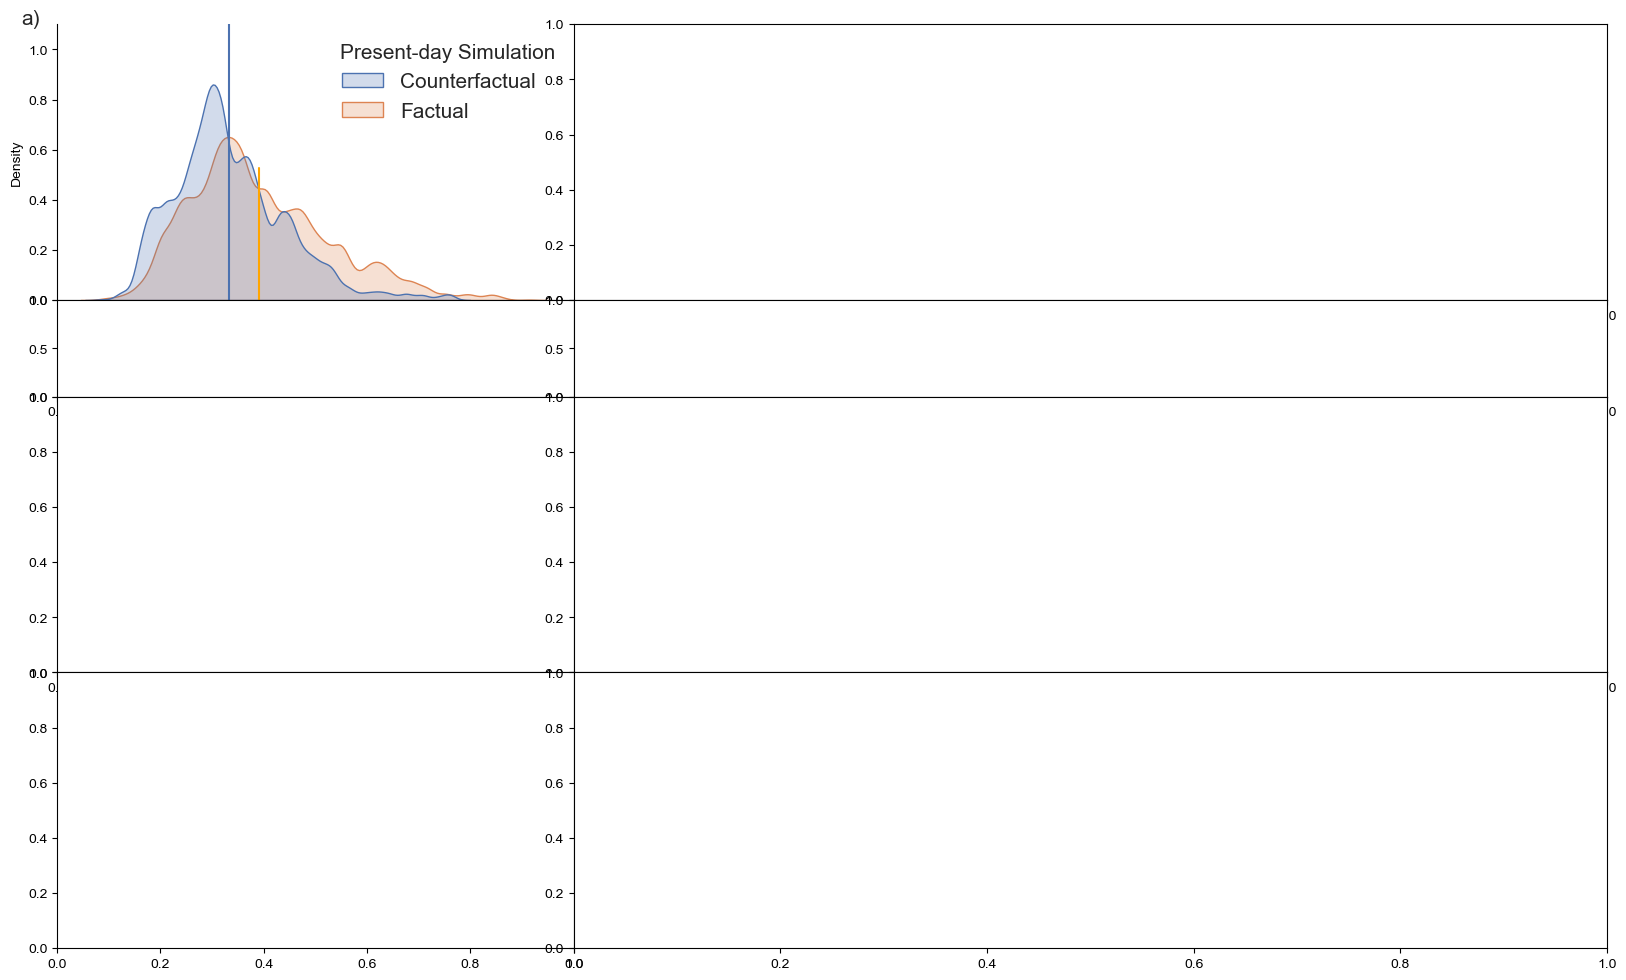

In [9]:
SEED = int.from_bytes("They're taking the hobbits to Isengard!".encode('utf-8'), byteorder='big')

'''
HPC = False

if HPC:
    ONEDRIVE_PATH = r'/vscmnt/brussel_pixiu_data/_data_brussel/vo/000/bvo00012/vsc10262/Wildfires/WP2_ISIMIP3a_BA_DA/OneDrive/PhD/Projects/ISIMIP3a_Burned_Area_Attribution/'
    directory_separator = '/'
else:
    ONEDRIVE_PATH = 'C:\\Users\\slampe\\OneDrive - Vrije Universiteit Brussel\\PhD\\Projects\\ISIMIP3a_Burned_Area_Attribution\\'
    directory_separator = '\\'
    
OBSERVATIONS_PATH = ONEDRIVE_PATH + 'Data/Observations/'.replace('/', directory_separator)
GFED4dot1s_PATH = OBSERVATIONS_PATH + 'GFED4.1s/GFED4.1s_Burned_Percentage.nc'.replace('/', directory_separator)
FireCCILT11_PATH = OBSERVATIONS_PATH + 'FireCCILT11/FireCCILT11_Burned_Percentage.nc'.replace('/', directory_separator)
MODEL_PATH = ONEDRIVE_PATH + 'Data/ISIMIP/ISIMIP3a/OutputData/fire/'.replace('/', directory_separator)
GFED_REGIONS_PATH = ONEDRIVE_PATH + 'Data/Supplementary_Data/base_regions.nc'.replace('/', directory_separator)
PLOTS_PATH = ONEDRIVE_PATH + 'Plots/'.replace('/', directory_separator)
DATA_PATH = ONEDRIVE_PATH + 'Data/'.replace('/', directory_separator)
SUPPLEMENTARY_DATA_PATH = DATA_PATH + 'Supplementary_Data/'.replace('/', directory_separator)
RESULTS_PATH = ONEDRIVE_PATH + 'Results/'.replace('/', directory_separator)
EGU_PLOT_PATH = 'C:\\Users\\slampe\\OneDrive - Vrije Universiteit Brussel\\PhD\\Events\\Conferences\\2023 EGU\\Plots\\'

obs_df = pd.read_pickle(f'{ONEDRIVE_PATH}Data//Supplementary_Data//AR6_obs_df.pkl')
obsclim_df = pd.read_pickle(f'{ONEDRIVE_PATH}Data//Supplementary_Data//AR6_obsclim_df.pkl')
counterclim_df = pd.read_pickle(f'{ONEDRIVE_PATH}Data//Supplementary_Data//AR6_counterclim_df.pkl')
model_weights = pd.read_pickle(f'{SUPPLEMENTARY_DATA_PATH}NME3_Weights.pkl')
'''

obs_df = pd.read_pickle(f'/scratch/cburton/scratch/ISIMIP3a/Data/AR6_obs_df.pkl')#2 obs, CCI5.1 & MCD64
obsclim_df = pd.read_pickle(f'/scratch/cburton/scratch/ISIMIP3a/Data/AR6_obsclim_df.pkl')
counterclim_df = pd.read_pickle(f'/scratch/cburton/scratch/ISIMIP3a/Data/AR6_counterclim_df.pkl')
model_weights = pd.read_pickle(f'/scratch/cburton/scratch/ISIMIP3a/Data/NME3_Weights.pkl')


##Obsclim
rng = np.random.default_rng(SEED)

obsclim_global = obsclim_df.groupby('Model', axis=1).sum()
counterclim_global = counterclim_df.groupby('Model', axis=1).sum()

obsclim = df_constrain_time(obsclim_global, 2003, 2019)
counterclim = df_constrain_time(counterclim_global, 2003, 2019)

df = (obsclim-counterclim.mean(axis=0))/counterclim.mean(axis=0)

series = pd.Series(df.values.ravel())
obsclim_sampled_global = series.sample(n=100000, weights=np.tile(select_region(model_weights, 'Global').values.ravel(), len(df.index)), random_state=rng, replace=True)

##Counterclim
rng = np.random.default_rng(SEED)

obsclim_global = obsclim_df.groupby('Model', axis=1).sum()
counterclim_global = counterclim_df.groupby('Model', axis=1).sum()

obsclim = df_constrain_time(obsclim_global, 2003, 2019)
counterclim = df_constrain_time(counterclim_global, 2003, 2019)

df = (counterclim-counterclim.mean(axis=0))/counterclim.mean(axis=0)

series = pd.Series(df.values.ravel())
counterclim_sampled_global = series.sample(n=100000, weights=np.tile(select_region(model_weights, 'Global').values.ravel(), len(df.index)), random_state=rng, replace=True)

## DHF PD
rng = np.random.default_rng(SEED)

counterclim_global = counterclim_df.groupby('Model', axis=1).sum()

dhf_early = df_constrain_time(counterclim_global, 1900, 1920)
counterclim = df_constrain_time(counterclim_global, 2003, 2019)

df = (counterclim-dhf_early.mean(axis=0))/dhf_early.mean(axis=0)

series = pd.Series(df.values.ravel())
counterclim_dhf_sampled_global = series.sample(n=100000, weights=np.tile(select_region(model_weights, 'Global').values.ravel(), len(df.index)), random_state=rng, replace=True)

## DHF early
rng = np.random.default_rng(SEED)

counterclim_global = counterclim_df.groupby('Model', axis=1).sum()

dhf_early = df_constrain_time(counterclim_global, 1900, 1920)
counterclim = df_constrain_time(counterclim_global, 2003, 2019)

df = (dhf_early-dhf_early.mean(axis=0))/dhf_early.mean(axis=0)

series = pd.Series(df.values.ravel())
dhf_early_sampled_global = series.sample(n=100000, weights=np.tile(select_region(model_weights, 'Global').values.ravel(), len(df.index)), random_state=rng, replace=True)





### Make Plot
fig, axs = plt.subplots(4, 2, gridspec_kw={'width_ratios': [1, 2], 'height_ratios': [1, 0.35, 1, 1], 'wspace': 0, 'hspace': 0}, figsize=(20, 12))
axs = axs.ravel()

sns.set_theme(style='white', rc={'axes.titlesize': 15, 'xtick.labelsize': 15, 'ytick.labelsize': 15, 'font.size': 15, 'legend.fontsize': 15, 'legend.title_fontsize': 15, 'axes.labelsize': 15})

boundaries = np.arange(-100, 101, 25)
n_colors = len(boundaries) + 1

cmap = sns.diverging_palette(245, 10, sep=1, n=n_colors)
cmap = mcolors.ListedColormap(cmap)
norm = mcolors.BoundaryNorm(boundaries=boundaries, ncolors=len(boundaries)+1, extend='both')
cbar = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

hexagons = gpd.read_file('/home/h01/cburton/PAPERS/5.Attribution/zones.gpkg').rename(columns={'label': 'Region'})
hexagons = hexagons.set_index('Region')


# Left-upper plot
ax = axs[0]
data = pd.concat([counterclim_sampled_global, obsclim_sampled_global], keys=['Counterfactual   ', 'Factual'], names=['Present-day Simulation'], axis=0).reset_index().drop('level_1', axis=1).rename(columns={0: 'Burned Area Relative Anomaly'})
sns.kdeplot(data, hue='Present-day Simulation', x='Burned Area Relative Anomaly', fill=True, ax=ax)

ax.axvline(x=counterclim_sampled_global.mean())#, ymin=0, ymax=0.605)
ax.axvline(x=obsclim_sampled_global.mean(), ymin=0, ymax=0.48, c='orange')
ax.set_ylim([0, 1.1])
sns.despine(ax=ax)
sns.move_legend(ax, loc='upper right', frameon=False, fontsize='medium', title_fontsize='medium')
ax.text(s='a)', x=ax.viewLim.get_points()[0, 0]-0.2, y=ax.viewLim.get_points()[1, 1])

# Right-upper plot
ax = axs[1]
hexagons_1 = pd.merge(hexagons, regional_fact_vs_cfact.to_frame().rename(columns={0: 'Burned Area Change'}), on='Region')
hexagons_1.plot(column='Burned Area Change', cmap=cmap, norm=norm, linewidth=0.8, edgecolor='gray', legend=False, ax=ax)
hexagons_1.apply(lambda x: ax.annotate(text=x.name, xy=x.geometry.centroid.coords[0], ha='center', fontsize=10), axis=1)

ax.set_axis_off()
ax.set_title('Climate Change', x=-0.05, y=1.05, fontsize=20)
ax.text(s='b)', x=ax.viewLim.get_points()[0, 0], y=ax.viewLim.get_points()[1, 1])


# Left-lower plot
ax = axs[4]
data = pd.concat([dhf_early_sampled_global, counterclim_dhf_sampled_global], keys=['Early industrial', 'Present-day'], names=['Counterfactual Period'], axis=0).reset_index().drop('level_1', axis=1).rename(columns={0: 'Burned Area Relative Anomaly'})
sns.kdeplot(data, hue='Counterfactual Period', x='Burned Area Relative Anomaly', fill=True, ax=ax)

ax.axvline(x=dhf_early_sampled_global.mean(), ymin=0, ymax=0.87)
ax.axvline(x=counterclim_dhf_sampled_global.mean(), ymin=0, ymax=0.65, c='orange')
ax.set_ylim([0, 1.1])
sns.despine(ax=ax)
sns.move_legend(ax, loc='upper right', frameon=False, fontsize='medium', title_fontsize='medium')
ax.text(s='c)', x=ax.viewLim.get_points()[0, 0]-0.2, y=ax.viewLim.get_points()[1, 1])

# Right-lower plot
ax = axs[5]
hexagons_2 = pd.merge(hexagons, regional_dhf_vs_cfact.to_frame().rename(columns={0: 'Burned Area Change'}), on='Region')
hexagons_2.plot(column='Burned Area Change', cmap=cmap, norm=norm, linewidth=0.8, edgecolor='gray', legend=False, ax=ax)
hexagons_2.apply(lambda x: ax.annotate(text=x.name, xy=x.geometry.centroid.coords[0], ha='center', fontsize=10), axis=1)

ax.set_axis_off()
ax.set_title('Direct Human Forcings', x=-0.05, y=1.05, fontsize=20)
ax.text(s='d)', x=ax.viewLim.get_points()[0, 0], y=ax.viewLim.get_points()[1, 1])

axs[2].set_axis_off()
axs[3].set_axis_off()

# NEW Left bottom plot
ax = axs[6]
data = pd.concat([dhf_early_sampled_global, obsclim_sampled_global], keys=['Counterfactual   ', 'Factual'], names=['Present-day Simulation'], axis=0).reset_index().drop('level_1', axis=1).rename(columns={0: 'Burned Area Relative Anomaly'})
sns.kdeplot(data, hue='Present-day Simulation', x='Burned Area Relative Anomaly', fill=True, ax=ax)

ax.axvline(x=dhf_early_sampled_global.mean(), ymin=0, ymax=0.605)
ax.axvline(x=obsclim_sampled_global.mean(), ymin=0, ymax=0.48, c='orange')
ax.set_ylim([0, 1.1])
sns.despine(ax=ax)
sns.move_legend(ax, loc='upper right', frameon=False, fontsize='medium', title_fontsize='medium')
ax.text(s='a)', x=ax.viewLim.get_points()[0, 0]-0.2, y=ax.viewLim.get_points()[1, 1])

#cbar.ax.tick_params(labelsize=10)

cbax = fig.add_axes([0.42, 0.04, 0.5, 0.25])
cbax.set_axis_off()
plt_cbar = plt.colorbar(cbar, orientation='horizontal', label='Burned Area Change (in %)', extend='both', pad=0, fraction=0.25, aspect=35, ax=cbax, anchor=(0.5, 0))

plt.tight_layout()
plt.savefig(f'{PLOTS_PATH}Figure 1.png', dpi=400, bbox_inches='tight')
#plt.show()
#bbox_inches='tight'

# Fig 2: Bar Plot

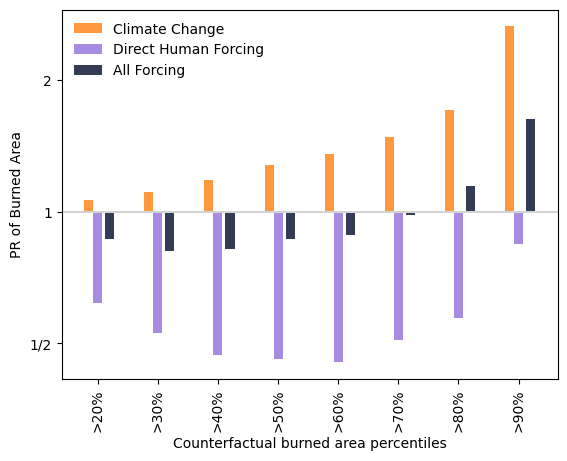

In [10]:

def scale_values_fig_2(array):
    return np.where(array>1, array-1, (1/-array)+1)


##ALL Obsclim
rng = np.random.default_rng(SEED)
obsclim_global = obsclim_df.groupby('Model', axis=1).sum()
counterclim_global = counterclim_df.groupby('Model', axis=1).sum()
obsclim = df_constrain_time(obsclim_global, 2003, 2019)
counterclim = df_constrain_time(counterclim_global, 1901, 1920)
df = (obsclim-counterclim.mean(axis=0))/counterclim.mean(axis=0)
series = pd.Series(df.values.ravel())
ALL_PD_sampled_global = series.sample(n=100000, weights=np.tile(select_region(model_weights, 'Global').values.ravel(), len(df.index)), random_state=rng, replace=True)

##ALL Counterclim
rng = np.random.default_rng(SEED)
df = (counterclim-counterclim.mean(axis=0))/counterclim.mean(axis=0)
series = pd.Series(df.values.ravel())
ALL_PI_sampled_global = series.sample(n=100000, weights=np.tile(select_region(model_weights, 'Global').values.ravel(), len(df.index)), random_state=rng, replace=True)


#Quantiles
quantiles = np.arange(20, 100, 10)
CClist = []
for quantile in quantiles:
    ALL_CC = (np.count_nonzero(obsclim_sampled_global > (np.percentile(counterclim_sampled_global, quantile))))
    NAT_CC = (np.count_nonzero(counterclim_sampled_global > (np.percentile(counterclim_sampled_global, quantile))))
    PR_CC = (ALL_CC/NAT_CC)
    CClist.append(PR_CC)
CClist = np.array(CClist)
CClist = scale_values_fig_2(CClist)

DHFlist = []
for quantile in quantiles:
    ALL_DHF = (np.count_nonzero(dhf_pd_sampled_global > (np.percentile(dhf_early_sampled_global, quantile))))
    NAT_DHF = (np.count_nonzero(dhf_early_sampled_global > (np.percentile(dhf_early_sampled_global, quantile))))
    PR_DHF = (ALL_DHF/NAT_DHF)
    DHFlist.append(PR_DHF)
DHFlist = np.array(DHFlist)
DHFlist = scale_values_fig_2(DHFlist)

ALLlist = []
for quantile in quantiles:
    ALL = (np.count_nonzero(ALL_PD_sampled_global > (np.percentile(ALL_PI_sampled_global, quantile))))
    NAT = (np.count_nonzero(ALL_PI_sampled_global > (np.percentile(ALL_PI_sampled_global, quantile))))
    PR = (ALL/NAT)
    ALLlist.append(PR)
ALLlist = np.array(ALLlist)
ALLlist = scale_values_fig_2(ALLlist)

    

xlabels = ('>20%', '>30%', '>40%', '>50%', '>60%', '>70%', '>80%', '>90%')
ylabels = ('1/2', '1', '2')
ypositions = [-1.0, 0.0, 1.0]
plt.bar(quantiles-1.5, CClist, width=1.5, align='center', color='#ff7f0e', label='Climate Change', alpha=0.8)
plt.bar(quantiles, DHFlist, width=1.5, align='center', color='mediumpurple', label='Direct Human Forcing', alpha=0.8)
plt.bar((quantiles+2), ALLlist, width=1.5, align='center', color='#000B29', label='All Forcing', alpha=0.8)

plt.ylabel("PR of Burned Area")
plt.xlabel("Counterfactual burned area percentiles")
plt.axhline(y=0.0, color='lightgrey')
plt.xticks(quantiles, xlabels, rotation=90)
plt.yticks(ypositions, ylabels)
plt.legend(frameon=False)
plt.show()



# Fig 3: Line plots

In [ ]:
obs_df = pd.read_pickle(f'{ONEDRIVE_PATH}Data//Supplementary_Data//AR6_obs_df.pkl')
obsclim_df = pd.read_pickle(f'{ONEDRIVE_PATH}Data//Supplementary_Data//AR6_obsclim_df.pkl')
counterclim_df = pd.read_pickle(f'{ONEDRIVE_PATH}Data//Supplementary_Data//AR6_counterclim_df.pkl')
model_weights = pd.read_pickle(f'{SUPPLEMENTARY_DATA_PATH}NME3_Weights.pkl')

###Global
warnings.filterwarnings('ignore') # Surpress some unimportant warnings
rng = np.random.default_rng(SEED)
ylabel = 'Overburning (%)'

years = 20 
co2 = pd.read_csv(f'{DATA_PATH}ISIMIP\\ISIMIP3a\\InputData\\co2_obsclim_annual_1850_2021.txt', header=None, sep=' ', names=['Date', 'CO2'])

sns.set_theme(style='white', rc={'axes.linewidth': 0.7, 'ytick.major.width':0.7, 'ytick.major.size':3, 'xtick.major.size':3, 'xtick.major.width':0.7})


fig = plt.figure(figsize=(5,4))

obsclim_annual = df_to_global(df_to_annual(obsclim_df))
counterclim_annual = df_to_global(df_to_annual(counterclim_df))
obsclim_annual_rolling_mean = obsclim_annual.rolling(years, closed='both', axis=0, min_periods=years//2, center=True).mean()
counterclim_annual_rolling_mean = counterclim_annual.rolling(years, closed='both', axis=0, min_periods=years//2, center=True).mean()

df = (obsclim_annual_rolling_mean - counterclim_annual_rolling_mean)/counterclim_annual_rolling_mean*100
df_sampled = df.sample(n=10000, weights=select_region(model_weights, 'Global').values.ravel(), random_state=rng, replace=True, axis=1)
df_sampled = prepare_for_facetgrid(df_sampled).rename(columns={'BA': ylabel})
df_sampled = df_sampled.merge(co2, how='inner', on='Date')

ax = sns.lineplot(data=df_sampled, x='Date', y=ylabel, color='red', figure=fig, errorbar=('pi'))
new_ax = plt.twinx()
sns.lineplot(data=df_sampled, x='Date',  y='CO2', color='black', linewidth=1, ax=new_ax)
new_ax.set_ylabel(f'$CO_2$')
new_ax.set(ylim=(250, 525))

data = df_sampled.groupby(['Date']).mean().reset_index()
x, y = data.loc[:, ylabel], data.loc[:, 'CO2']
corr = pearsonr(x.values, y.values)
test = ax.text(x=1900, y=df_sampled.loc[:, ylabel].max() * 0.95, s=f'r = {round(corr[0], 3)}', fontsize=10)

ax.set_xlabel('Year')
ax.set_title('Global', fontsize=15)

plt.savefig(f'{PLOTS_PATH}Global_co2vsBA', dpi=400, bbox_inches='tight')

In [25]:
## 4 Regions
def add_var(x, y, color, data, ylabel, scale_param, **kwargs):
    new_ax = plt.twinx()
    sns.lineplot(data=data, x=x, y=y, color=color, ax=new_ax, **kwargs)
    new_ax.set_ylabel(ylabel)
    ymax = (data.max()[scale_param]/data.groupby('Date').mean().reset_index().max()[scale_param])*100 + 300
    new_ax.set(ylim=(290, ymax))
    
def add_var2(x, y, color, data, ylabel, **kwargs):
    new_ax = plt.twinx()
    sns.lineplot(data=data, x=x, y=y, color=color, ax=new_ax, **kwargs)
    new_ax.set_ylabel(ylabel)
       
def add_corr(x, y, data, **kwargs):
    ymin, ymax = data.loc[:, x].min(), data.loc[:, x].max()
    y_text = ymin + (ymax - ymin)*0.91
    data = data.groupby(['Date', 'Region']).mean().reset_index()
    x, y = data.loc[:, x], data.loc[:, y]
    corr = pearsonr(x.values, y.values)
    plt.text(x=1900, y=y_text, s=f'r = {round(corr[0], 3)}', fontsize=10)
    
    
warnings.filterwarnings('ignore') # Surpress some unimportant warnings
rng = np.random.default_rng(SEED)
height = 2.5
years = 20
ylabel = 'BA Change (in %)'

regionnames_full = {'WNA': 'Western North-America (WNA)', 'WSB': 'Western Siberia (WSB)', 'SES': 'Southeastern South-America (SES)', 'CAU': 'Central Australia (CAU)'}
regionnames_short = {value: key for key, value in regionnames_full.items()}

obsclim_annual = df_to_annual(obsclim_df)
counterclim_annual = df_to_annual(counterclim_df)
obsclim_annual_rolling_mean = obsclim_annual.rolling(years, closed='both', axis=0, min_periods=years//2, center=True).mean()
counterclim_annual_rolling_mean = counterclim_annual.rolling(years, closed='both', axis=0, min_periods=years//2, center=True).mean()

df = (obsclim_annual_rolling_mean - counterclim_annual_rolling_mean)/counterclim_annual_rolling_mean
df = df.loc[:, regionnames_full.keys()]*100
df = df.rename(columns=regionnames_full)

df_sampled = pd.DataFrame(index=pd.MultiIndex.from_product([df.index, np.arange(10000)], names=['Date', 'idx']), columns=df.columns.unique(level='Region'))

for regionname in df.columns.unique(level='Region'):
    region_data = df.loc[:, regionname]
    df_sampled.loc[:, regionname] = region_data.sample(n=10000, weights=select_region(model_weights, regionnames_short[regionname]).values.ravel(), random_state=rng, replace=True, axis=1).values.ravel()

df_sampled = prepare_for_facetgrid(df_sampled).rename(columns={'BA': ylabel}).drop('idx', axis=1)
df_sampled = df_sampled.merge(co2, how='inner', on='Date')

figure = sns.relplot(data=df_sampled, x='Date', y=ylabel, col="Region", color='red', height=height, col_wrap=2, aspect=2, kind='line', facet_kws={'sharey': False}, errorbar=('pi'))
figure.map_dataframe(add_var, x='Date', y='CO2', color='black', linewidth=1, ylabel=f'CO$_2$', scale_param = ylabel)
figure.map_dataframe(add_corr, x=ylabel, y='CO2', data=figure.data)
figure.set_xlabels(label='Year')
figure.set_ylabels(label='BA change (in %)')
figure.set_titles(col_template="{col_name}", fontsize=15)

figure.set(xticks=np.arange(1900, 2021, 20))

ba_line = matplotlib.lines.Line2D([], [], color='red', label='BA')
co2_line = matplotlib.lines.Line2D([], [], color='black', linewidth=1, label='CO$_2$')
figure.axes[-1].legend(handles=[ba_line, co2_line], loc='center left', frameon=False)

figure.savefig(PLOTS_PATH+'weighted_relative_anomaly_trend_rolling_selected.png', dpi=400)

NameError: name 'co2' is not defined

# Extended Data Figure 1: Selected Regions

/var/tmp/ipykernel_36836/1050869374.py:22: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data, hist=False, kde=True,  label=model_name, ax=ax, kde_kws={'linewidth': 4,'color':model_colours[model_name]})
/var/tmp/ipykernel_36836/1050869374.py:22: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

 

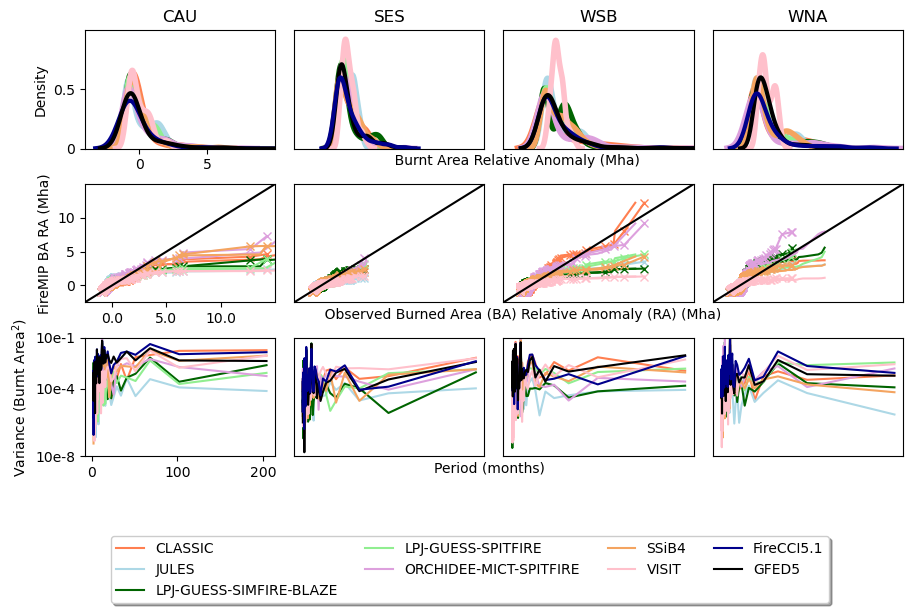

In [7]:
SelectedRegions = ['CAU', 'SES','WSB', 'WNA']

obs_colours= {'GFED5':'black', 'FireCCI5.1':'darkblue'} 

model_colours = {'JULES': 'lightblue', 
              'CLASSIC': 'coral', 
              'SSiB4': 'sandybrown',
              'LPJ-GUESS-SPITFIRE': 'lightgreen',
            'LPJ-GUESS-SIMFIRE-BLAZE': 'darkgreen',
            'ORCHIDEE-MICT-SPITFIRE':'plum',
             'VISIT':'pink'}

fig, axs = plt.subplots(3, 4, figsize=(9, 5))
axs = axs.ravel() 

#PDF
for idx, regionname in enumerate(SelectedRegions):
    ax = axs[idx]
    for model_name in obsclim_0319_Ranom[regionname].columns: 
        #if model_name != 'VISIT':    
            data = obsclim_0319_Ranom[regionname][model_name]
            sns.distplot(data, hist=False, kde=True,  label=model_name, ax=ax, kde_kws={'linewidth': 4,'color':model_colours[model_name]})                
    for obs_name in obs_0319_Ranom[regionname].columns:
        if obs_name == 'GFED5' or obs_name == 'FireCCI5.1':
            data = obs_0319_Ranom[regionname][obs_name]
            sns.distplot(data, hist=False, kde=True, label=obs_name, ax=ax, kde_kws={'linewidth': 3,'color':obs_colours[obs_name]})
    ax.set_title(regionname)
    ax.set_xlabel(' ') 
    ax.set_ylabel(' ') 
    #ax.set_ylim(0,0.8)
    ax.set_ylim(0,1.0)
    ax.set_xlim(-4,10) 
    ax.set_xticks([], [])
    ax.set_yticks([], [])
    plt.tight_layout()

    
#QQ    
for idx, regionname in enumerate(SelectedRegions):
    ax = axs[idx+4]
    for model_name in obsclim_0319_Ranom[regionname].columns:
        ax.plot(np.sort(obs_0319_Ranom[regionname]['GFED5']), np.sort(obsclim_0319_Ranom[regionname][model_name]), marker='x', color=model_colours[model_name], label=model_name)
        ax.plot(np.sort(obs_0319_Ranom[regionname]['FireCCI5.1']), np.sort(obsclim_0319_Ranom[regionname][model_name]), color=model_colours[model_name])
    axis_min=-2.5
    axix_max=15.0#10.0
    ax.plot([axis_min,axix_max],[axis_min,axix_max],color="k")
    ax.set_ylim(axis_min,axix_max)
    ax.set_xlim(axis_min,axix_max)    
    ax.set_xticks([], [])
    ax.set_yticks([], [])
    ax.set_xlabel(' ') 
    ax.set_ylabel(' ') 
    

##power
   
for idx, regionname in enumerate(SelectedRegions):
    ax = axs[idx+8]
    for model_name in obsclim_0319_Ranom[regionname].columns: 
        f, sp = periodogram(obsclim_0319_Ranom[regionname][model_name], detrend='constant',scaling='spectrum')
        ax.plot(1./f, sp, color=model_colours[model_name], label=model_name)     
    for obs_name in obs_0319_Ranom[regionname].columns:
        if obs_name == 'GFED5' or obs_name == 'FireCCI5.1':
            f, sp = periodogram(obs_0319_Ranom[regionname][obs_name], detrend='constant',scaling='spectrum')
            ax.plot(1./f, sp, color=obs_colours[obs_name], label=obs_name)   
    ax.set_yscale('log')
    ax.set_xlabel(' ') 
    ax.set_ylabel(' ')
    ax.set_ylim(10e-8,10e-1)
    ax.set_xticks([], [])
    ax.set_yticks([], [])

box = axs[8].get_position()
axs[8].set_position([box.x0, box.y0, box.width * 0.9, box.height])
axs[8].legend(bbox_to_anchor=(0.1, -1.3), loc="lower left",
          fancybox=True, shadow=True, ncol=4)

axs[0].set_ylabel('Density') 
axs[0].set_yticks([0,0.5],['0', '0.5']) 
axs[0].set_xticks([0,5], ['0','5']) 
axs[4].set_ylabel('FireMIP BA RA (Mha)')
axs[4].set_yticks([0,5,10],['0', '5', '10']) 
axs[4].set_xticks([0.0,5.0,10.0], ['0.0','5.0','10.0']) 
axs[8].set_ylabel('Variance (Burnt Area$^2$)')
axs[8].set_yticks([10e-8,10e-4,10e-1],['10e-8','10e-4','10e-1']) 
axs[8].set_xticks([0,100,200], ['0','100','200']) 
axs[1].set_xlabel('                       Burnt Area Relative Anomaly (Mha)', loc="left")     
axs[5].set_xlabel('       Observed Burned Area (BA) Relative Anomaly (RA) (Mha)', loc="left")     
axs[9].set_xlabel('                                Period (months)', loc="left")     

plt.subplots_adjust(wspace=0.1, hspace=0.3)
#plt.savefig('/scratch/cburton/scratch/ISIMIP3a/Draft3.0/Validation_4Regions.png',facecolor='w', transparent=False)    
plt.show()

    

# Fig S1: Cveg change maps

jules


/opt/scitools/conda/deployments/default-2022_11_22/lib/python3.9/site-packages/iris/coords.py:2223: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))
/opt/scitools/conda/deployments/default-2022_11_22/lib/python3.9/site-packages/iris/coords.py:2223: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))
/opt/scitools/conda/deployments/default-2022_11_22/lib/python3.9/site-packages/iris/coords.py:2048: UserWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  warnings.warn(
/opt/scitools/conda/deployments/default-2022_11_22/lib/python3.9/site-packages/iris/coords.py:2048: UserWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  warnings.warn(
/opt/scitools/conda/deployments/default-2022_11_22/lib/python3.9/site-packages/iris/fileformats/netcdf.py:481: UserWarn

classic


/opt/scitools/conda/deployments/default-2022_11_22/lib/python3.9/site-packages/iris/coords.py:2223: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))
/opt/scitools/conda/deployments/default-2022_11_22/lib/python3.9/site-packages/iris/coords.py:2223: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))
/opt/scitools/conda/deployments/default-2022_11_22/lib/python3.9/site-packages/iris/coords.py:2048: UserWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  warnings.warn(
/opt/scitools/conda/deployments/default-2022_11_22/lib/python3.9/site-packages/iris/coords.py:2048: UserWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  warnings.warn(


orchidee


/opt/scitools/conda/deployments/default-2022_11_22/lib/python3.9/site-packages/iris/coords.py:2223: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))
/opt/scitools/conda/deployments/default-2022_11_22/lib/python3.9/site-packages/iris/coords.py:2223: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))
/opt/scitools/conda/deployments/default-2022_11_22/lib/python3.9/site-packages/iris/coords.py:2048: UserWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  warnings.warn(
/opt/scitools/conda/deployments/default-2022_11_22/lib/python3.9/site-packages/iris/coords.py:2048: UserWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  warnings.warn(


visit


/opt/scitools/conda/deployments/default-2022_11_22/lib/python3.9/site-packages/iris/coords.py:2223: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))
/opt/scitools/conda/deployments/default-2022_11_22/lib/python3.9/site-packages/iris/coords.py:2223: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))
/opt/scitools/conda/deployments/default-2022_11_22/lib/python3.9/site-packages/iris/coords.py:2048: UserWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  warnings.warn(
/opt/scitools/conda/deployments/default-2022_11_22/lib/python3.9/site-packages/iris/coords.py:2048: UserWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  warnings.warn(


ssib4


/opt/scitools/conda/deployments/default-2022_11_22/lib/python3.9/site-packages/iris/coords.py:2223: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))
/opt/scitools/conda/deployments/default-2022_11_22/lib/python3.9/site-packages/iris/coords.py:2223: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))
/opt/scitools/conda/deployments/default-2022_11_22/lib/python3.9/site-packages/iris/coords.py:2048: UserWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  warnings.warn(
/opt/scitools/conda/deployments/default-2022_11_22/lib/python3.9/site-packages/iris/coords.py:2048: UserWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  warnings.warn(


LPJ-GUESS-SPITFIRE


/opt/scitools/conda/deployments/default-2022_11_22/lib/python3.9/site-packages/iris/coords.py:2223: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))
/opt/scitools/conda/deployments/default-2022_11_22/lib/python3.9/site-packages/iris/coords.py:2223: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))
/opt/scitools/conda/deployments/default-2022_11_22/lib/python3.9/site-packages/iris/coords.py:2048: UserWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  warnings.warn(
/opt/scitools/conda/deployments/default-2022_11_22/lib/python3.9/site-packages/iris/coords.py:2048: UserWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  warnings.warn(


LPJ-GUESS-SIMFIRE-BLAZE


/opt/scitools/conda/deployments/default-2022_11_22/lib/python3.9/site-packages/iris/coords.py:2223: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))
/opt/scitools/conda/deployments/default-2022_11_22/lib/python3.9/site-packages/iris/coords.py:2223: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'time'.
  warnings.warn(msg.format(self.name()))
/opt/scitools/conda/deployments/default-2022_11_22/lib/python3.9/site-packages/iris/coords.py:2048: UserWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  warnings.warn(
/opt/scitools/conda/deployments/default-2022_11_22/lib/python3.9/site-packages/iris/coords.py:2048: UserWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  warnings.warn(
/var/tmp/ipykernel_43122/2064831549.py:68: UserWarning: This figure includes Axes that are not compatible with tight_la

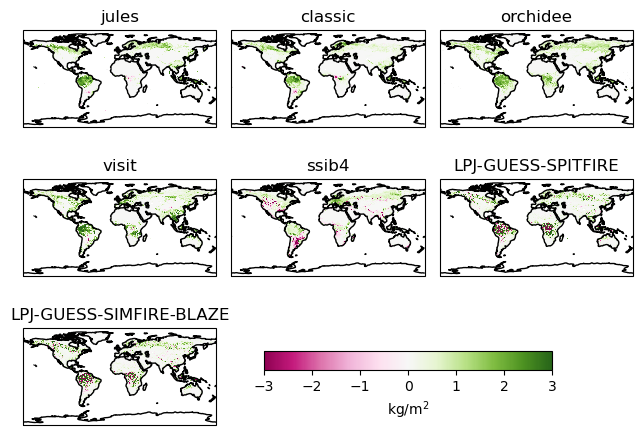

In [151]:
import iris
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import cf_units
import cftime
from iris.plot import pcolormesh
import iris.quickplot as qplt
import iris.plot as iplt
from iris.coord_systems import GeogCS
from iris.coords import DimCoord
import iris.coord_categorisation
import numpy.ma as ma

folder = '/scratch/cburton/scratch/ISIMIP3a/Data/cveg/'

def UpdateTime(cube):
    timeco = cube.coord('time')
    assert timeco.units == cf_units.Unit('months since 1901-01-01 00:00:00', calendar='proleptic_gregorian')
    timeco.units = cf_units.Unit('days since 1901-01-01 00:00:00', calendar='360_day')
    timeco.points = timeco.points * 30.
    iris.coord_categorisation.add_month(cube, 'time', name='month')
    return cube

def ConstrainTime(cube):
    date = iris.Constraint(time=lambda cell: 2003 <= cell.point.year <= 2019) 
    cube = cube.extract(date)
    return cube

def CollapseLonLat(cube):
    coords = ('longitude', 'latitude')
    for coord in coords:
        if not cube.coord(coord).has_bounds():
            cube.coord(coord).guess_bounds()
    grid_weights = iris.analysis.cartography.area_weights(cube)
    cube = cube.collapsed(['latitude', 'longitude'], iris.analysis.SUM, weights = grid_weights) /1E12
    return cube

models = ('jules', 'classic', 'orchidee', 'visit', 'ssib4', 'LPJ-GUESS-SPITFIRE', 'LPJ-GUESS-SIMFIRE-BLAZE')

n = 1
for model in models:
    print(model)
    Obsclim = iris.load_cube(folder+model+'*gswp3-w5e5_obsclim_histsoc*cveg*_1901_2019.nc')
    if model == 'jules':
        Obsclim = UpdateTime(Obsclim)
    Obsclim = ConstrainTime(Obsclim)
    Obsclim = Obsclim.collapsed(['time'], iris.analysis.MEAN)

    Counterclim = iris.load_cube(folder+model+'*gswp3-w5e5_counterclim_histsoc*cveg*_1901_2019.nc')
    if model == 'jules':
        Counterclim = UpdateTime(Counterclim)
    Counterclim = ConstrainTime(Counterclim)
    Counterclim = Counterclim.collapsed(['time'], iris.analysis.MEAN)

    Difference = Obsclim - Counterclim

    plt.subplot(3,3,n)
    mesh=iplt.pcolormesh(Difference, cmap='PiYG', vmin=-3, vmax=3)
    plt.gca().coastlines()
    plt.title(model)
    n=n+1
                         #Position: Left, Bottom, width, height
colorbar_axes = plt.gcf().add_axes([0.4, 0.2, 0.45, 0.04])
colorbar = plt.colorbar(mesh, colorbar_axes, orientation='horizontal', label='kg/m$^2$') #, pad=0.08, )
plt.tight_layout()
plt.show()




# Fig S2: PDFs 1901 & 1950 

NameError: name 'PLOTS_PATH' is not defined

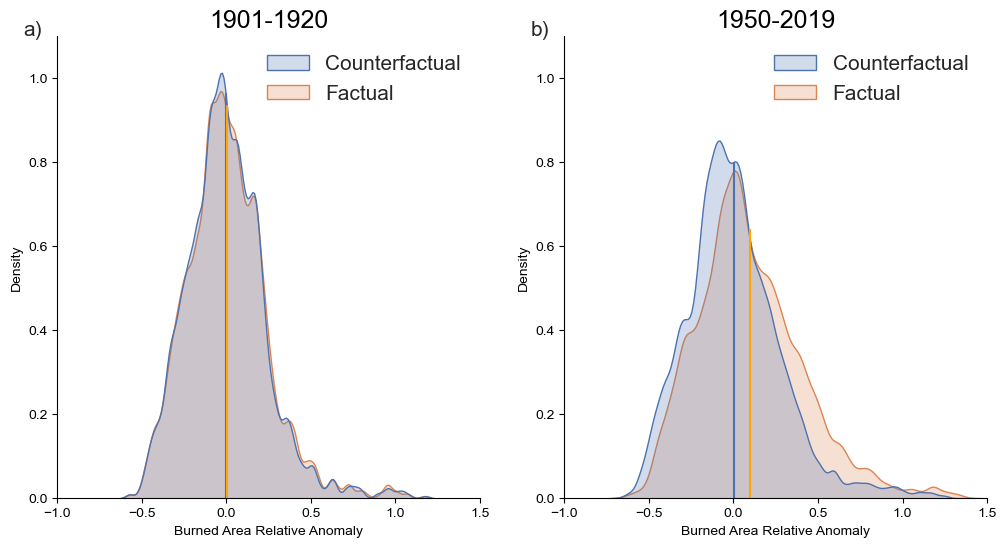

In [153]:
obs = pd.read_pickle(f'/scratch/cburton/scratch/ISIMIP3a/Data/AR6_obs_df.pkl')#2 obs, CCI5.1 & MCD64
obsclim = pd.read_pickle(f'/scratch/cburton/scratch/ISIMIP3a/Data/AR6_obsclim_df.pkl')
counterclim = pd.read_pickle(f'/scratch/cburton/scratch/ISIMIP3a/Data/AR6_counterclim_df.pkl')
model_weights = pd.read_pickle(f'/scratch/cburton/scratch/ISIMIP3a/Data/NME3_Weights.pkl')


## Create 1901-1920 obsclim
rng = np.random.default_rng(SEED)

obsclim_global = obsclim_df.groupby('Model', axis=1).sum()
counterclim_global = counterclim_df.groupby('Model', axis=1).sum()

obsclim = df_constrain_time(obsclim_global, 1901, 1920)
counterclim = df_constrain_time(counterclim_global, 1901, 1920)

df = (obsclim-counterclim.mean(axis=0))/counterclim.mean(axis=0)

series = pd.Series(df.values.ravel())
obsclim_sampled_global_1901_1920 = series.sample(n=100000, weights=np.tile(select_region(model_weights, 'Global').values.ravel(), len(df.index)), random_state=rng, replace=True)

## Create 1950-2019 obsclim
rng = np.random.default_rng(SEED)

obsclim_global = obsclim_df.groupby('Model', axis=1).sum()
counterclim_global = counterclim_df.groupby('Model', axis=1).sum()

obsclim = df_constrain_time(obsclim_global, 1950, 2019)
counterclim = df_constrain_time(counterclim_global, 1950, 2019)

df = (obsclim-counterclim.mean(axis=0))/counterclim.mean(axis=0)

series = pd.Series(df.values.ravel())
obsclim_sampled_global_1950_2019 = series.sample(n=100000, weights=np.tile(select_region(model_weights, 'Global').values.ravel(), len(df.index)), random_state=rng, replace=True)

## Create 1901-1920 counterclim
rng = np.random.default_rng(SEED)

obsclim_global = obsclim_df.groupby('Model', axis=1).sum()
counterclim_global = counterclim_df.groupby('Model', axis=1).sum()

obsclim = df_constrain_time(obsclim_global, 1901, 1920)
counterclim = df_constrain_time(counterclim_global, 1901, 1920)

df = (counterclim-counterclim.mean(axis=0))/counterclim.mean(axis=0)

series = pd.Series(df.values.ravel())
counterclim_sampled_global_1901_1920 = series.sample(n=100000, weights=np.tile(select_region(model_weights, 'Global').values.ravel(), len(df.index)), random_state=rng, replace=True)

## Create 1950-2019 counterclim
rng = np.random.default_rng(SEED)

obsclim_global = obsclim_df.groupby('Model', axis=1).sum()
counterclim_global = counterclim_df.groupby('Model', axis=1).sum()

obsclim = df_constrain_time(obsclim_global, 1950, 2019)
counterclim = df_constrain_time(counterclim_global, 1950, 2019)

df = (counterclim-counterclim.mean(axis=0))/counterclim.mean(axis=0)

series = pd.Series(df.values.ravel())
counterclim_sampled_global_1950_2019 = series.sample(n=100000, weights=np.tile(select_region(model_weights, 'Global').values.ravel(), len(df.index)), random_state=rng, replace=True)


### Create figure
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs = axs.ravel()

sns.set_theme(style='white', rc={'axes.titlesize': 15, 'xtick.labelsize': 15, 'ytick.labelsize': 15, 'font.size': 15, 'legend.fontsize': 15, 'legend.title_fontsize': 15, 'axes.labelsize': 15})

ax = axs[0]
data = pd.concat([counterclim_sampled_global_1901_1920, obsclim_sampled_global_1901_1920], keys=['Counterfactual', 'Factual'], names=['1901-1920'], axis=0).reset_index().drop('level_1', axis=1).rename(columns={0: 'Burned Area Relative Anomaly'})
sns.kdeplot(data, hue='1901-1920', x='Burned Area Relative Anomaly', fill=True, ax=ax)

ax.axvline(x=counterclim_sampled_global_1901_1920.mean(), ymin=0, ymax=0.875)
ax.axvline(x=obsclim_sampled_global_1901_1920.mean(), ymin=0, ymax=0.85, c='orange')
ax.set_ylim([0, 1.1])
ax.set_xlim([-1, 1.5])
ax.set_title('1901-1920', fontsize='large')
sns.despine(ax=ax)
sns.move_legend(ax, loc='upper right', frameon=False, fontsize='medium', title_fontsize='medium', title='')
ax.text(s='a)', x=ax.viewLim.get_points()[0, 0]-0.2, y=ax.viewLim.get_points()[1, 1])


ax = axs[1]
data = pd.concat([counterclim_sampled_global_1950_2019, obsclim_sampled_global_1950_2019], keys=['Counterfactual', 'Factual'], names=['1950-2019'], axis=0).reset_index().drop('level_1', axis=1).rename(columns={0: 'Burned Area Relative Anomaly'})
sns.kdeplot(data, hue='1950-2019', x='Burned Area Relative Anomaly', fill=True, ax=ax)

ax.axvline(x=counterclim_sampled_global_1950_2019.mean(), ymin=0, ymax=0.725)
ax.axvline(x=obsclim_sampled_global_1950_2019.mean(), ymin=0, ymax=0.58, c='orange')
ax.set_ylim([0, 1.1])
ax.set_xlim([-1, 1.5])
ax.set_title('1950-2019', fontsize='large')
sns.despine(ax=ax)
sns.move_legend(ax, loc='upper right', frameon=False, fontsize='medium', title_fontsize='medium', title='')
_ = ax.text(s='b)', x=ax.viewLim.get_points()[0, 0]-0.2, y=ax.viewLim.get_points()[1, 1])

plt.savefig(PLOTS_PATH+'2pdfs_weighted.png', dpi=300, bbox_inches='tight')    

# Fig S3: Regional overburning & CO2 plots (Seppe)

In [3]:
obs_df = pd.read_pickle(f'{ONEDRIVE_PATH}Data//Supplementary_Data//AR6_obs_df.pkl')
obsclim_df = pd.read_pickle(f'{ONEDRIVE_PATH}Data//Supplementary_Data//AR6_obsclim_df.pkl')
counterclim_df = pd.read_pickle(f'{ONEDRIVE_PATH}Data//Supplementary_Data//AR6_counterclim_df.pkl')
model_weights = pd.read_pickle(f'{SUPPLEMENTARY_DATA_PATH}NME3_Weights.pkl') 


warnings.filterwarnings('ignore') # Surpress some unimportant warnings
years = 20
ylabel = 'Change in BA (in %)'

sns.set_theme(style='white', rc={'axes.linewidth': 0.7, 'ytick.major.width':0.7, 'ytick.major.size':3, 'xtick.major.size':3, 'xtick.major.width':0.7})

co2 = pd.read_csv(f'{DATA_PATH}ISIMIP\\ISIMIP3a\\InputData\\co2_obsclim_annual_1850_2021.txt', header=None, sep=' ', names=['Date', 'CO2'])
obsclim_annual = df_to_annual(obsclim_df)
counterclim_annual = df_to_annual(counterclim_df)
obsclim_annual_rolling_mean = obsclim_annual.rolling(years, closed='both', axis=0, min_periods=years//2, center=True).mean()
counterclim_annual_rolling_mean = counterclim_annual.rolling(years, closed='both', axis=0, min_periods=years//2, center=True).mean()

df = (obsclim_annual_rolling_mean - counterclim_annual_rolling_mean)/counterclim_annual_rolling_mean
df = df.multiply(model_weights.drop(labels='Global', axis=1).values, axis=1)

df = df.drop(columns=('ARP', 'ORCHIDEE-MICT-SPITFIRE'))
df.loc[:, 'ARP'] = (df.loc[:, 'ARP']/select_region(model_weights, 'ARP').drop(columns='ORCHIDEE-MICT-SPITFIRE', level=1).sum(axis=1).values[0]).values

df = df.groupby(axis=1, level='Region').sum()
df = prepare_for_facetgrid(df).rename(columns={'BA': ylabel})
df = df.merge(co2, how='inner', on='Date')
height = 2.5

figure = sns.relplot(data=df, x='Date', y=ylabel, col="Region", color='red', height=height, col_wrap=4, aspect=2, kind='line', facet_kws={'sharey': False})
figure.map_dataframe(add_var, x='Date', y='CO2', color='black', linewidth=1, ylabel=f'CO$_2$', scale_param=ylabel)
figure.map_dataframe(add_corr, x=ylabel, y='CO2', data=figure.data)
figure.set_titles(col_template="{col_name}", fontsize=15)
figure.set_xlabels(label='Year')
figure.set_ylabels(label='BA change (in %)')

figure.set(xticks=np.arange(1900, 2021, 20))

ba_line = matplotlib.lines.Line2D([], [], color='red', label='BA')
co2_line = matplotlib.lines.Line2D([], [], color='black', linewidth=1, label='CO$_2$')
figure.axes[-1].legend(handles=[ba_line, co2_line], loc='lower right',frameon=False)

figure.savefig(f'{PLOTS_PATH}weighted_relative_anomaly_trend_rolling.png', dpi=600, bbox_inches = 'tight')
warnings.filterwarnings('default')

NameError: name 'DATA_PATH' is not defined

# Fig S4: Overburning trend hexagon plot (Seppe)

In [ ]:
df = prepare_for_facetgrid(sampled_df.loc[1980:]).explode('BA')
df = df.replace(np.inf, np.nan).dropna() # ORCHIDEE has inf values (divided by 0) in ARP, let's get rid of them
regions = np.unique(df.Region.values)
trend_df = pd.Series(np.full(regions.size, np.nan), index=regions)
for regionname in trend_df.index:
    data = df[df.Region == regionname]
    X = sm.add_constant(data.Date.values)
    Y = data.BA.values.astype(np.float64)
    model = sm.OLS(Y,X)
    trend_df.loc[regionname] = model.fit()
    
trend_boundaries_df = pd.DataFrame(columns=['Boundary 1', 'Boundary 2'], index=trend_df.index)
for regionname in trend_df.index:
    trend_boundaries_df.loc[regionname] = trend_df[regionname].conf_int()[1]
    
temp_df = (trend_boundaries_df.sort_values(by='Boundary 1', ascending=False)*100)
means = temp_df.mean(axis=1)
spread = (temp_df['Boundary 2'] - temp_df['Boundary 1'])/2
pd.concat([means, spread], axis=1).rename(columns={0: 'Trend', 1: 'Spread'}).astype(float).round(3)*40

cmap=sns.diverging_palette(250, 10, sep=1, n=15)
cmap

hexagons = gpd.read_file(DATA_PATH+'Supplementary_Data/ipcc-master/zones.gpkg').rename(columns={'label': 'Region'})
trend_df = trend_boundaries_df.mean(axis=1).reset_index().rename(columns={'index': 'Region', 0: 'Trend'})
trend_df['Trend']*=100
hexagons = hexagons.merge(trend_df, on='Region')

cmap=sns.diverging_palette(240, 10, sep=1, n=8)
cmap = mcolors.ListedColormap(cmap.as_hex())
trend_min, trend_max = -1, 1

vmin, vmax, vcenter= trend_min, trend_max, 0
norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
cbar = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

ax = hexagons.plot()
hexagons.plot(column='Trend', cmap=cmap, norm=norm, linewidth=0.8, edgecolor='gray', legend=False, ax=ax)
hexagons.apply(lambda x: ax.annotate(text=x['Region'], xy=x.geometry.centroid.coords[0], ha='center', fontsize=6), axis=1);
plt.colorbar(cbar, orientation='horizontal', label='Trend (% change per year)', extend='both', pad=0.05)
plt.axis('off')
plt.savefig(PLOTS_PATH+'Hexagons_trend.png', dpi=300, bbox_inches='tight')
plt.show()

# Fig S4: Burnt Area Maps

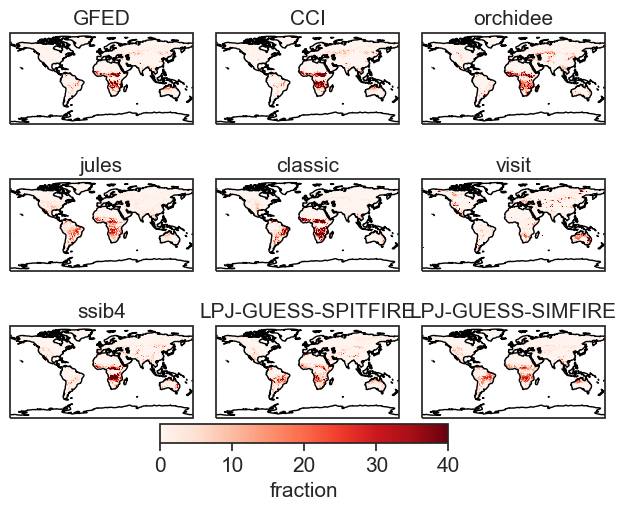

In [44]:

def UpdateTime(cube):
    timeco = cube.coord('time')
    assert timeco.units == cf_units.Unit('months since 1901-01-01', calendar='360_day')
    timeco.units = cf_units.Unit('days since 1901-01-01', calendar='360_day')
    timeco.points = timeco.points * 30.
    return cube

def ConstrainTime(cube):
    date = iris.Constraint(time=lambda cell: 2003 <= cell.point.year <= 2019) 
    cube = cube.extract(date)
    return cube

def MonthlyToAnnual(cube):
    iris.coord_categorisation.add_season_year(cube, 'time', name='year')
    cube = cube.aggregated_by(['year'],iris.analysis.SUM)
    cube = cube.collapsed(['time'], iris.analysis.MEAN)
    return cube



##### Load Obs Data ##### 
AllObs = ('GFED', 'CCI')
n = 1
for ob in AllObs:
    obs = iris.load_cube('~/GitHub/ISIMIP3a/Observations/*'+ob+'*Burned_Percentage.nc')
    obs = ConstrainTime(obs)
    obs = MonthlyToAnnual(obs)
    
    plt.subplot(3,3,n)
    mesh=iplt.pcolormesh(obs, vmin=0, vmax=40, cmap='Reds')
    plt.gca().coastlines()
    plt.title(ob)
    n=n+1


##### Load Model Data ##### 
folder = '/scratch/cburton/scratch/ISIMIP3a/Data/'
models = ['orchidee', 'jules', 'classic','visit', 'ssib4', 'LPJ-GUESS-SPITFIRE', 'LPJ-GUESS-SIMFIRE']
n = 3
for model in models:
    cube = iris.load_cube(folder+model+'*_gswp3-w5e5_obsclim_histsoc_default_burntarea-total_global_monthly_1901_2019.nc')
    if model == 'orchidee':
        cube.remove_coord(cube.coords('time')[1]) # Remove Auxcoord (was there already)
        month_lengths = np.array([(np.arange(f'{2005}-{str(x).rjust(2, "0")}', f'{2005+x//12}-{str(x%12+1).rjust(2, "0")}', dtype='datetime64[D]')).size for x in range(1, 13)]).repeat(cube.coords('time')[0].points.size//12)
        cube = iris.analysis.maths.multiply(cube, month_lengths[:, None, None], dim='time')
    elif model == 'LPJ-GUESS-SPITFIRE' or model == 'LPJ-GUESS-SIMFIRE':
        cube.data = ma.masked_where(np.isnan(cube.data),cube.data)
    else:
       cube = UpdateTime(cube)
    cube = ConstrainTime(cube)
    cube = MonthlyToAnnual(cube)
    if model == 'classic':
        cube = cube*100 #Convert frac to percent
    if model == 'ssib4':
        cube = cube*30 #Convert %/day to %/month

    plt.subplot(3,3,n)
    mesh=iplt.pcolormesh(cube, vmin=0, vmax=40, cmap='Reds')
    plt.gca().coastlines()
    plt.title(model)
    n=n+1

                   #Position from: Left, Bottom, width, height
colorbar_axes = plt.gcf().add_axes([0.27, 0.04, 0.45, 0.04])
colorbar = plt.colorbar(mesh, colorbar_axes, orientation='horizontal', label='Percentage burned area')
plt.tight_layout()
plt.show()



# Fig S4: Temp and Precip Maps

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(10, 14), subplot_kw={'projection': ccrs.Robinson()})
axs = axs.ravel()

# Temperature
ax = axs[0]
temp_obsclim = xr.open_dataset(f'{DATA_PATH}ISIMIP\\ISIMIP3a\\InputData\\gswp3-w5e5_obsclim_tas_global_yearly.nc')
temp_counterclim = xr.open_dataset(f'{DATA_PATH}ISIMIP\\ISIMIP3a\\InputData\\gswp3-w5e5_counterclim_tas_global_yearly.nc')
temp_diff = temp_obsclim - temp_counterclim

temp_diff.tas[-17:].reduce(np.mean, 'time').plot.imshow(ax=ax, vmin=0, vmax=3, levels=13, transform=ccrs.PlateCarree(), cmap='Reds', cbar_kwargs={'location': 'bottom', 'orientation': 'horizontal', 'label': 'Temperature Difference (in °C)'})

ax.add_feature(cartopy.feature.COASTLINE, zorder=5)
ax.add_feature(cartopy.feature.OCEAN, zorder=10)

# Precipitation
ax = axs[1]
n_colors = 13
cmap = sns.diverging_palette(10, 245, sep=1, as_cmap=True)
pr_obsclim = xr.open_dataset(f'{DATA_PATH}ISIMIP\\ISIMIP3a\\InputData\\gswp3-w5e5_obsclim_pr_global_yearly.nc')
pr_counterclim = xr.open_dataset(f'{DATA_PATH}ISIMIP\\ISIMIP3a\\InputData\\gswp3-w5e5_counterclim_pr_global_yearly.nc')
pr_diff = (pr_obsclim - pr_counterclim) * 60 * 60 * 24 # Convert from mm/s to mm/year (no need to multiply by 365 since we already took the sum)

pr_diff.pr[-17:].reduce(np.mean, 'time').plot.imshow(ax=ax, vmin=-1000, vmax=1000, levels=n_colors, transform=ccrs.PlateCarree(), cmap=cmap, cbar_kwargs={'location': 'bottom', 'orientation': 'horizontal', 'label': 'Yearly Precipitation Difference (in mm/year)'})

ax.add_feature(cartopy.feature.COASTLINE, zorder=5)
ax.add_feature(cartopy.feature.OCEAN, zorder=10)
plt.tight_layout()
plt.savefig(f'{PLOTS_PATH}Temp_precip.png', dpi=400, bbox_inches = 'tight')

# Fig S5: Time series

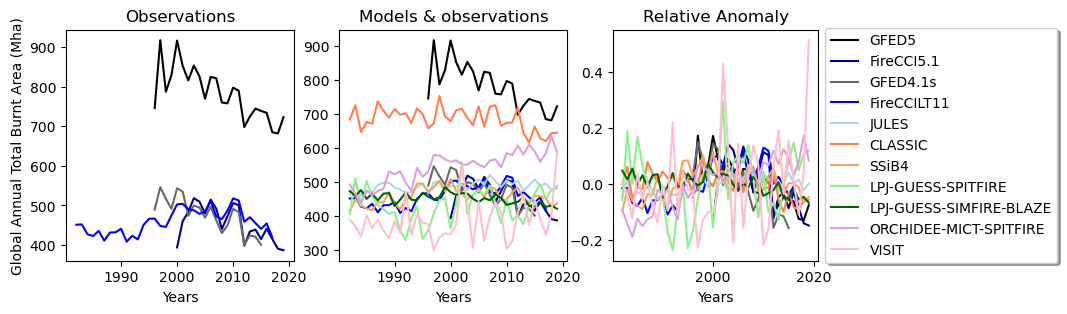

In [4]:
obscolors= ('white','black', 'darkblue', 'dimgrey','blue') 
AllObs = ['GFED5','FireCCI5.1','GFED4.1s', 'FireCCILT11', ]


fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(1,3,1)
x1 = np.arange(1982,2020)
n=1
for Data in AllObs:
    ax.plot(x1,obs_annual_glob[Data], color = obscolors[n % len(obscolors)], label=Data)
    n = n+1
plt.xlabel('Years')
plt.ylabel('Global Annual Total Burnt Area (Mha)')
plt.title('Observations')


ax2 = fig.add_subplot(1,3,2)
x = np.arange(1901,2020)
n=1
for Data in AllObs:
    ax2.plot(x1,obs_annual_glob[Data], color = obscolors[n % len(obscolors)], label=Data)
    n = n+1
modelcolors= ('white','lightblue', 'coral', 'sandybrown', 'lightgreen','darkgreen', 'plum', 'pink') 
AllModels = ['JULES', 'CLASSIC', 'SSiB4', 'LPJ-GUESS-SPITFIRE','LPJ-GUESS-SIMFIRE-BLAZE', 'ORCHIDEE-MICT-SPITFIRE', 'VISIT']
n=1
for Data in AllModels:
    ax2.plot(x1,obsclim_8219_annual_glob[Data], color = modelcolors[n % len(modelcolors)], label=Data)
    n = n+1
plt.xlabel('Years')
plt.title('Models & observations')


ax3 = fig.add_subplot(1,3,3)
n=1
for Data in AllObs:
    ax3.plot(x1,obs_annual_glob_Ranom[Data], color = obscolors[n % len(obscolors)], label=Data)
    n = n+1
n=1
for Data in AllModels:
    ax3.plot(x1,obsclim_8219_annual_glob_Ranom[Data], color = modelcolors[n % len(modelcolors)], label=Data)
    n = n+1
box = ax3.get_position()
ax3.set_position([box.x0, box.y0, box.width * 0.9, box.height])
ax3.legend(bbox_to_anchor=(1.0, 0.5), loc="center left",
          fancybox=True, shadow=True, ncol=1)
plt.xlabel('Years')
plt.title('Relative Anomaly')
plt.show()

# Fig S6 / S7: Validation PDF (Monthly, Regions, Relative Anomaly)

/var/tmp/ipykernel_43122/3333564353.py:20: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data, hist=False, kde=True,  label=model_name, ax=ax, kde_kws={'linewidth': 4,'color':model_colours[model_name]})
/var/tmp/ipykernel_43122/3333564353.py:20: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

 

/var/tmp/ipykernel_43122/3333564353.py:24: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data, hist=False, kde=True, label=obs_name, ax=ax, kde_kws={'linewidth': 3,'color':obs_colours[obs_name]})
/var/tmp/ipykernel_43122/3333564353.py:24: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.di

/var/tmp/ipykernel_43122/3333564353.py:24: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data, hist=False, kde=True, label=obs_name, ax=ax, kde_kws={'linewidth': 3,'color':obs_colours[obs_name]})
/var/tmp/ipykernel_43122/3333564353.py:24: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.di

/var/tmp/ipykernel_43122/3333564353.py:20: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data, hist=False, kde=True,  label=model_name, ax=ax, kde_kws={'linewidth': 4,'color':model_colours[model_name]})
/var/tmp/ipykernel_43122/3333564353.py:20: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

 

/var/tmp/ipykernel_43122/3333564353.py:20: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data, hist=False, kde=True,  label=model_name, ax=ax, kde_kws={'linewidth': 4,'color':model_colours[model_name]})
/var/tmp/ipykernel_43122/3333564353.py:20: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

 

/var/tmp/ipykernel_43122/3333564353.py:20: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data, hist=False, kde=True,  label=model_name, ax=ax, kde_kws={'linewidth': 4,'color':model_colours[model_name]})
/var/tmp/ipykernel_43122/3333564353.py:20: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

 

/var/tmp/ipykernel_43122/3333564353.py:20: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data, hist=False, kde=True,  label=model_name, ax=ax, kde_kws={'linewidth': 4,'color':model_colours[model_name]})
/var/tmp/ipykernel_43122/3333564353.py:20: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

 

/var/tmp/ipykernel_43122/3333564353.py:24: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data, hist=False, kde=True, label=obs_name, ax=ax, kde_kws={'linewidth': 3,'color':obs_colours[obs_name]})
/var/tmp/ipykernel_43122/3333564353.py:24: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.di

/var/tmp/ipykernel_43122/3333564353.py:20: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data, hist=False, kde=True,  label=model_name, ax=ax, kde_kws={'linewidth': 4,'color':model_colours[model_name]})
/var/tmp/ipykernel_43122/3333564353.py:20: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

 

/var/tmp/ipykernel_43122/3333564353.py:20: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data, hist=False, kde=True,  label=model_name, ax=ax, kde_kws={'linewidth': 4,'color':model_colours[model_name]})
/var/tmp/ipykernel_43122/3333564353.py:20: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

 

/var/tmp/ipykernel_43122/3333564353.py:20: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data, hist=False, kde=True,  label=model_name, ax=ax, kde_kws={'linewidth': 4,'color':model_colours[model_name]})
/var/tmp/ipykernel_43122/3333564353.py:20: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

 

/var/tmp/ipykernel_43122/3333564353.py:24: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data, hist=False, kde=True, label=obs_name, ax=ax, kde_kws={'linewidth': 3,'color':obs_colours[obs_name]})
/var/tmp/ipykernel_43122/3333564353.py:24: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.di

/var/tmp/ipykernel_43122/3333564353.py:20: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data, hist=False, kde=True,  label=model_name, ax=ax, kde_kws={'linewidth': 4,'color':model_colours[model_name]})
/var/tmp/ipykernel_43122/3333564353.py:20: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

 

/var/tmp/ipykernel_43122/3333564353.py:20: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data, hist=False, kde=True,  label=model_name, ax=ax, kde_kws={'linewidth': 4,'color':model_colours[model_name]})
/var/tmp/ipykernel_43122/3333564353.py:20: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

 

/var/tmp/ipykernel_43122/3333564353.py:24: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data, hist=False, kde=True, label=obs_name, ax=ax, kde_kws={'linewidth': 3,'color':obs_colours[obs_name]})
/var/tmp/ipykernel_43122/3333564353.py:20: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.di

/var/tmp/ipykernel_43122/3333564353.py:20: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data, hist=False, kde=True,  label=model_name, ax=ax, kde_kws={'linewidth': 4,'color':model_colours[model_name]})
/var/tmp/ipykernel_43122/3333564353.py:20: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

 

/var/tmp/ipykernel_43122/3333564353.py:24: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data, hist=False, kde=True, label=obs_name, ax=ax, kde_kws={'linewidth': 3,'color':obs_colours[obs_name]})
/var/tmp/ipykernel_43122/3333564353.py:20: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.di

/var/tmp/ipykernel_43122/3333564353.py:20: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data, hist=False, kde=True,  label=model_name, ax=ax, kde_kws={'linewidth': 4,'color':model_colours[model_name]})
/var/tmp/ipykernel_43122/3333564353.py:20: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

 

/var/tmp/ipykernel_43122/3333564353.py:20: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data, hist=False, kde=True,  label=model_name, ax=ax, kde_kws={'linewidth': 4,'color':model_colours[model_name]})
/var/tmp/ipykernel_43122/3333564353.py:20: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

 

/var/tmp/ipykernel_43122/3333564353.py:24: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data, hist=False, kde=True, label=obs_name, ax=ax, kde_kws={'linewidth': 3,'color':obs_colours[obs_name]})
/var/tmp/ipykernel_43122/3333564353.py:24: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.di

/var/tmp/ipykernel_43122/3333564353.py:20: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data, hist=False, kde=True,  label=model_name, ax=ax, kde_kws={'linewidth': 4,'color':model_colours[model_name]})
/var/tmp/ipykernel_43122/3333564353.py:20: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

 

/var/tmp/ipykernel_43122/3333564353.py:42: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(obs_0319_Ranom_glob[Data], hist=False, kde=True, ax=ax,
/var/tmp/ipykernel_43122/3333564353.py:42: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(obs_0319_Ranom_glob[Data], hist=False, kde=T

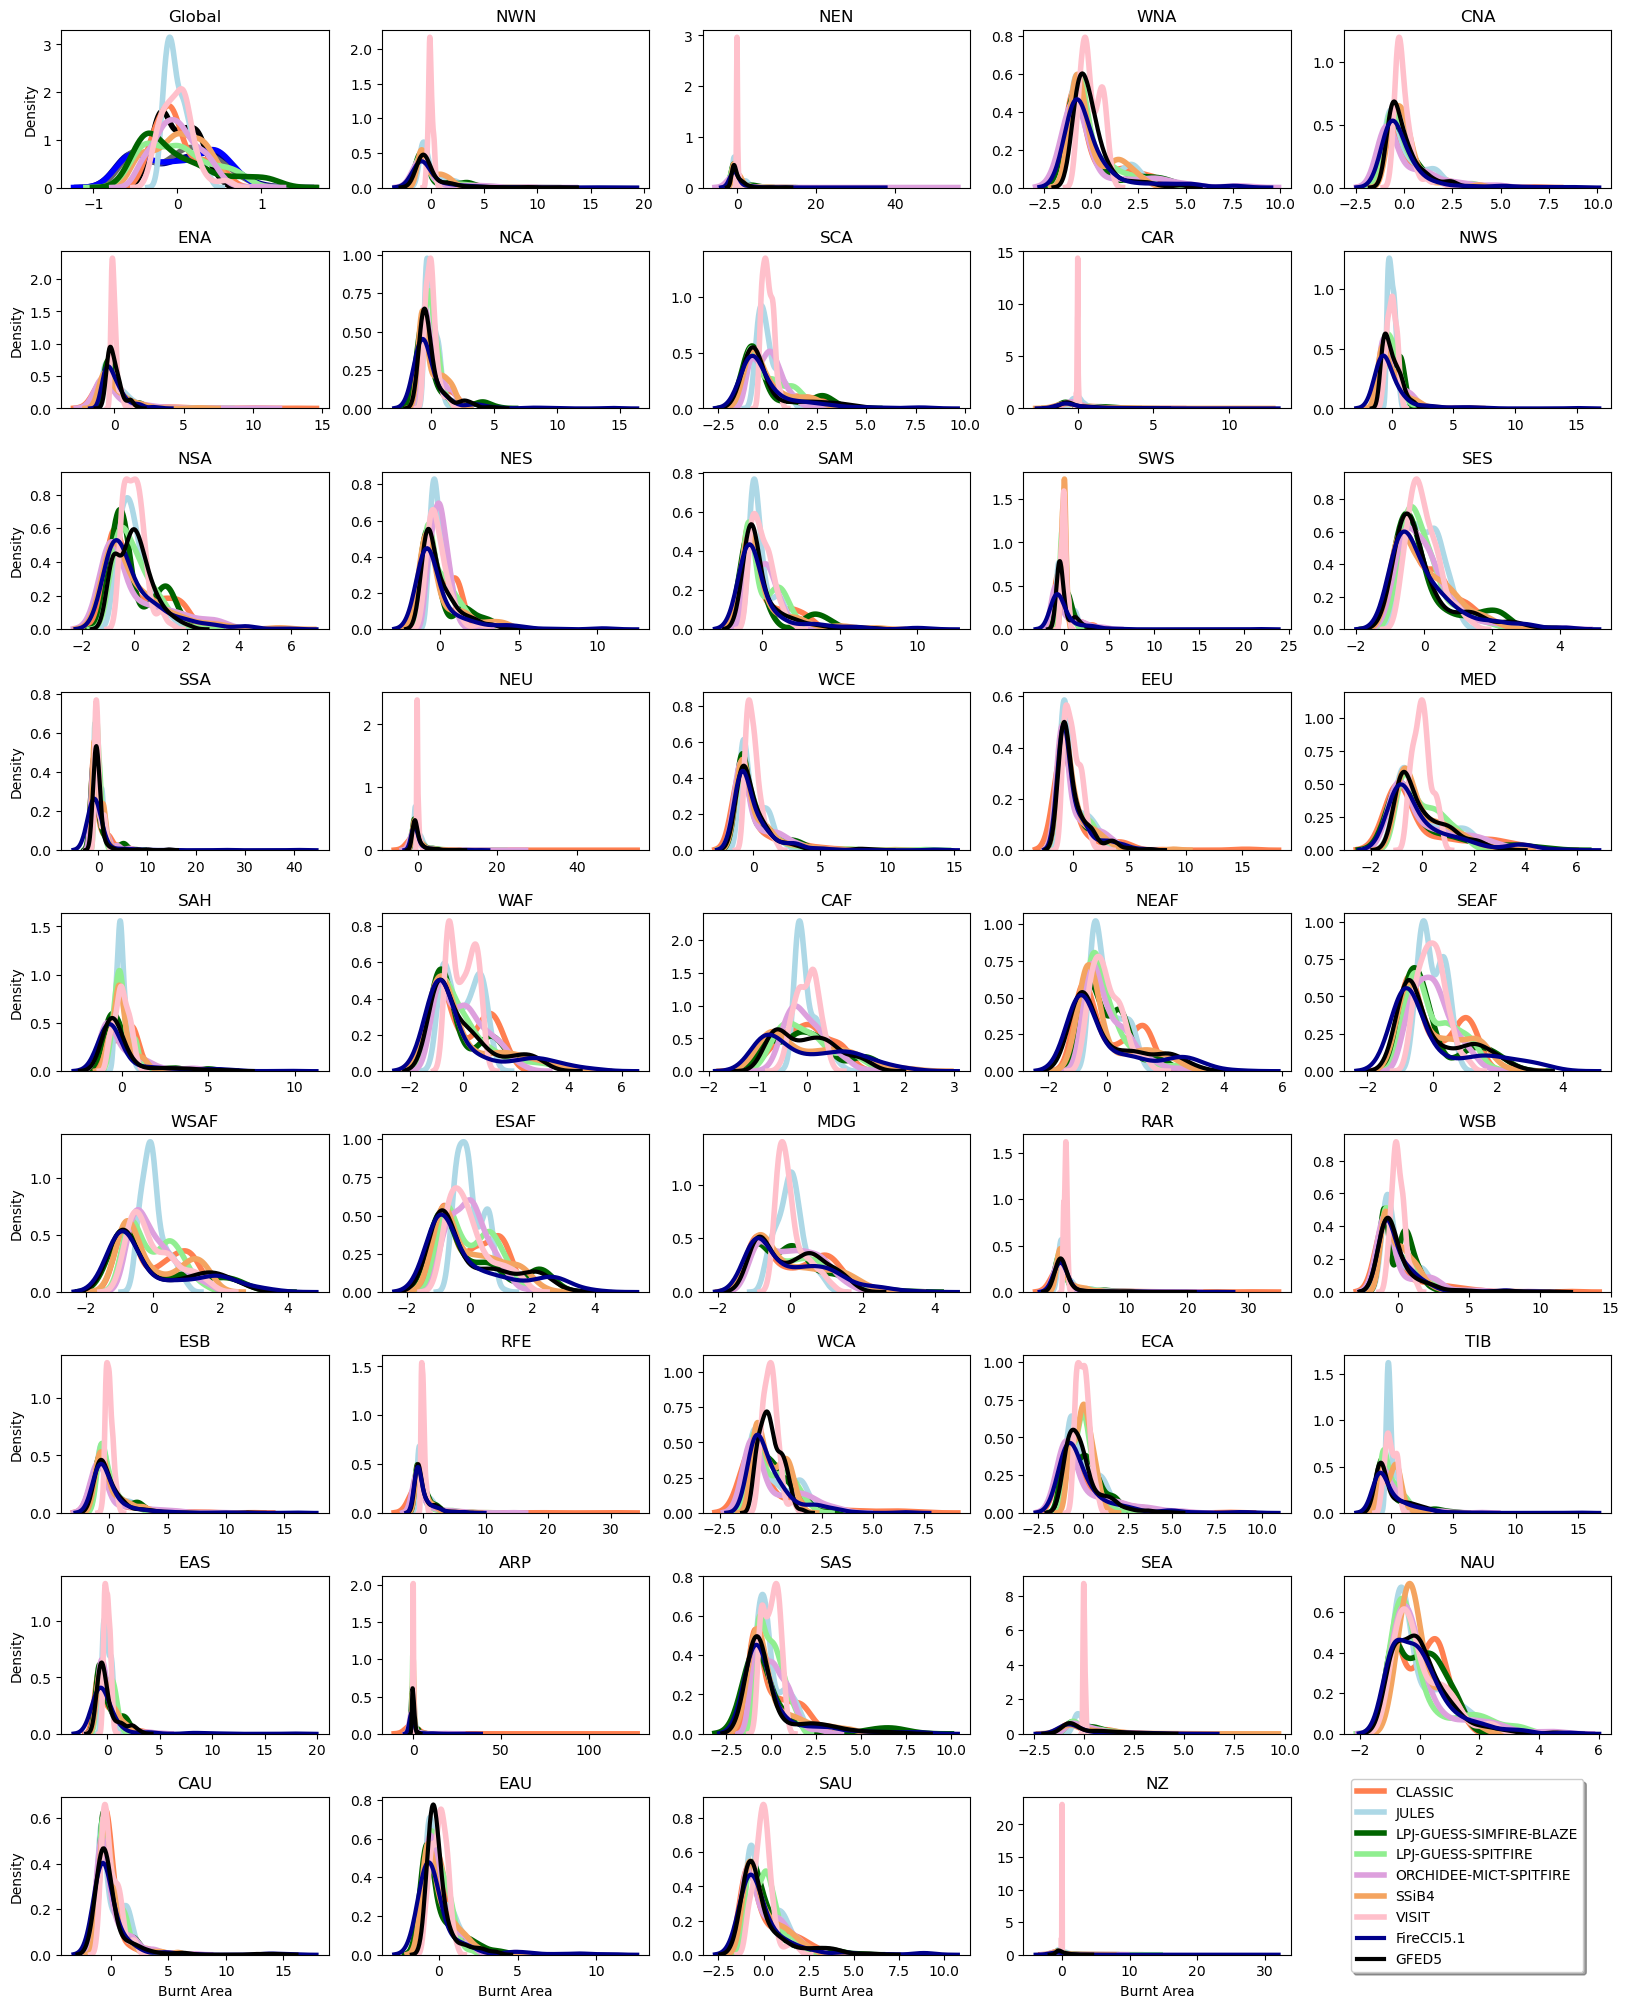

In [149]:
obs_colours= {'GFED5':'black', 'FireCCI5.1':'darkblue'} 

model_colours = {'JULES': 'lightblue', 
              'CLASSIC': 'coral', 
              'SSiB4': 'sandybrown',
              'LPJ-GUESS-SPITFIRE': 'lightgreen',
            'LPJ-GUESS-SIMFIRE-BLAZE': 'darkgreen',
            'ORCHIDEE-MICT-SPITFIRE':'plum',
             'VISIT':'pink'}

fig, axs = plt.subplots(9, 5, figsize=(20, 25))
axs = axs.ravel()

#Do all the regions
for idx, regionname in enumerate(obsclim_0319_Ranom.columns.unique(level='Region')):
    ax = axs[idx+1]
    for model_name in obsclim_0319_Ranom[regionname].columns: 
        #if model_name != 'VISIT':    
            data = obsclim_0319_Ranom[regionname][model_name]
            sns.distplot(data, hist=False, kde=True,  label=model_name, ax=ax, kde_kws={'linewidth': 4,'color':model_colours[model_name]})                
    for obs_name in obs_0319_Ranom[regionname].columns:
        if obs_name == 'GFED5' or obs_name == 'FireCCI5.1':
            data = obs_0319_Ranom[regionname][obs_name]
            sns.distplot(data, hist=False, kde=True, label=obs_name, ax=ax, kde_kws={'linewidth': 3,'color':obs_colours[obs_name]})
    ax.set_title(regionname)
    ax.set_ylabel(' ')
    ax.set_xlabel(' ')


plt.delaxes(axs[-1])
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.9, box.height])
ax.legend(bbox_to_anchor=(1.2, 0.5), loc="center left",
          fancybox=True, shadow=True, ncol=1)


#Now do the global plot
#AllModels = ['JULES', 'CLASSIC', 'SSiB4', 'LPJ-GUESS-SPITFIRE','LPJ-GUESS-SIMFIRE-BLAZE', 'ORCHIDEE-MICT-SPITFIRE']
ax = axs[0]
n=1
for Data in AllObs:
    sns.distplot(obs_0319_Ranom_glob[Data], hist=False, kde=True, ax=ax,
                 color = obscolors[n % len(obscolors)], 
                 hist_kws={'edgecolor':obscolors[n % len(obscolors)]},
                 kde_kws={'linewidth': 4, 'color': obscolors[n % len(obscolors)], 'label':Data})
    n = n+1    
n=1
for Data in AllModels:  
    sns.distplot(obsclim_0319_Ranom_glob[Data], hist=False, kde=True, ax=ax,
                 color = modelcolors[n % len(modelcolors)], 
                 hist_kws={'edgecolor':modelcolors[n % len(modelcolors)]},
                 kde_kws={'linewidth': 4, 'color': modelcolors[n % len(modelcolors)], 'label':Data})
    n = n+1         
ax.set_xlabel(' ')
ax.set_ylabel(' ') 
ax.set_title('Global')

#Set the axis labels
for ax in axs[40:44]:
    ax.set_xlabel('Burnt Area')
PlotsNos = [0,5,10,15,20,25,30,35,40]   
for ax in axs[PlotsNos]:
    ax.set_ylabel('Density')
plt.subplots_adjust(hspace=0.4)
plt.savefig('/scratch/cburton/scratch/ISIMIP3a/Draft3.0/AR6regions_Ranom_wVISIT.png',facecolor='w', transparent=False)    
plt.show()


# Fig S8: QQ plots all regions

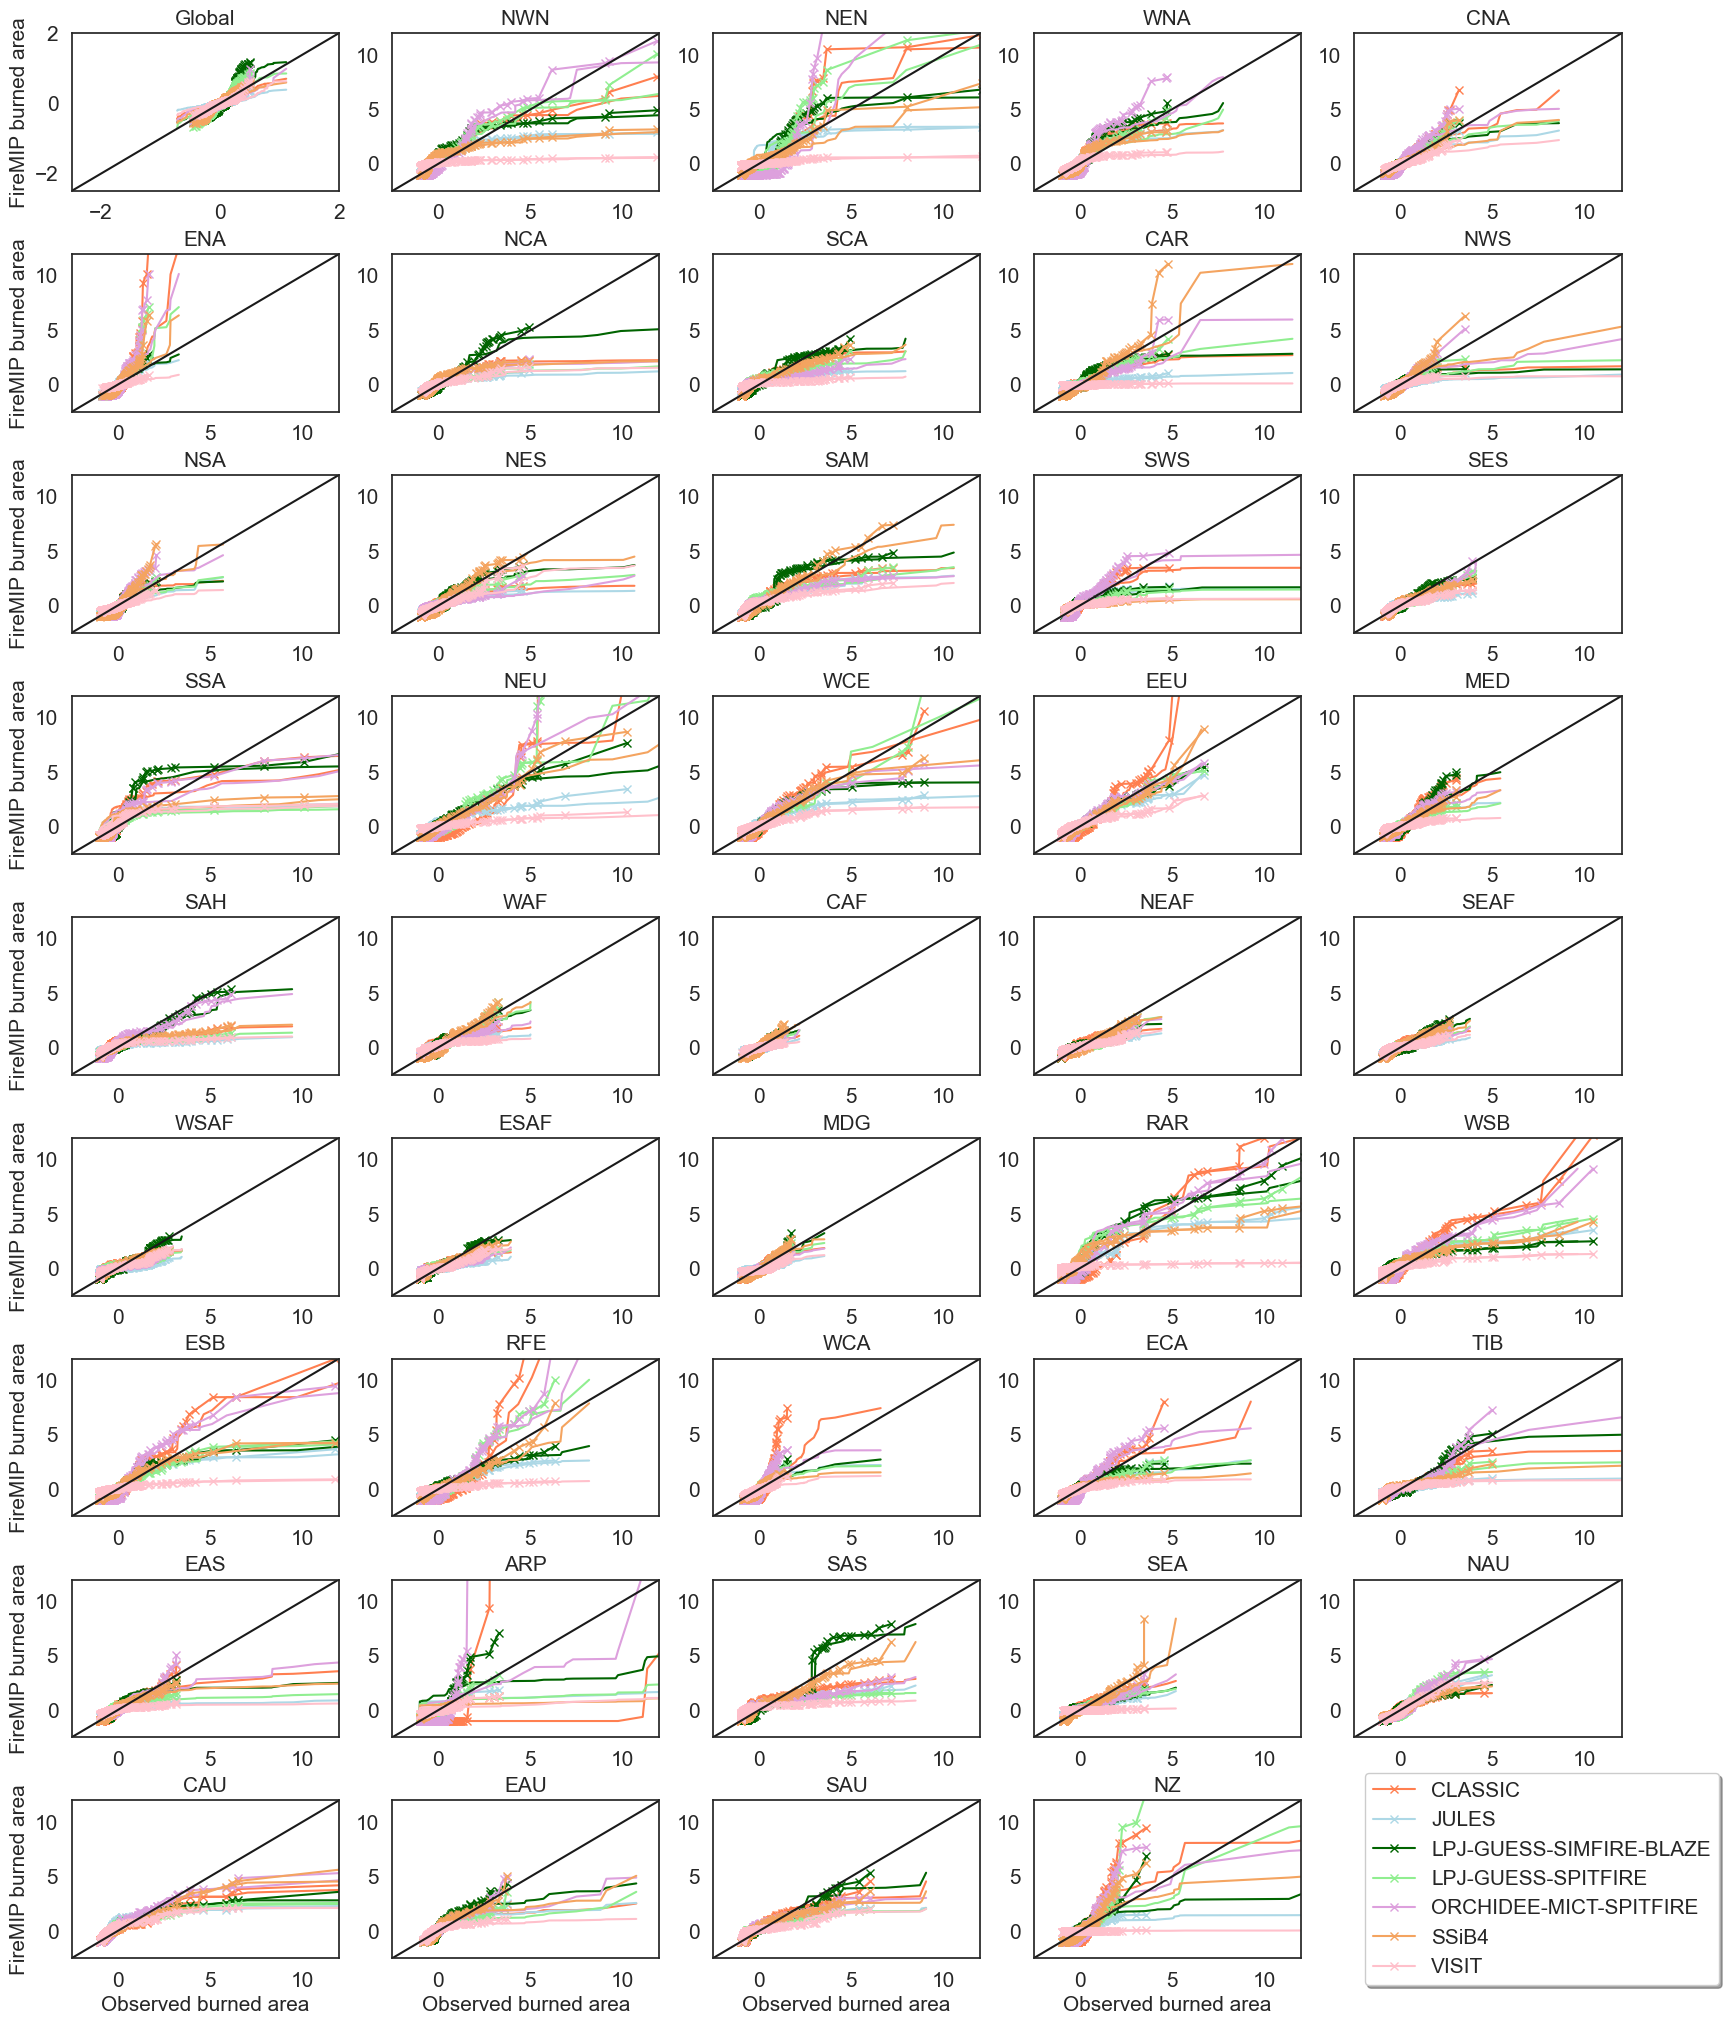

In [12]:


model_colours = {'JULES': 'lightblue', 
              'CLASSIC': 'coral', 
              'SSiB4': 'sandybrown',
              'LPJ-GUESS-SPITFIRE': 'lightgreen',
            'LPJ-GUESS-SIMFIRE-BLAZE': 'darkgreen',
            'ORCHIDEE-MICT-SPITFIRE':'plum',
             'VISIT':'pink'}


fig, axs = plt.subplots(9, 5, figsize=(20, 25))
axs = axs.ravel()

#Plot all regions
for idx, regionname in enumerate(obsclim_0319_Ranom.columns.unique(level='Region')):
    ax = axs[idx+1]
    for model_name in obsclim_0319_Ranom[regionname].columns:
        ax.plot(np.sort(obs_0319_Ranom[regionname]['GFED5']), np.sort(obsclim_0319_Ranom[regionname][model_name]), marker='x', color=model_colours[model_name], label=model_name)
        ax.plot(np.sort(obs_0319_Ranom[regionname]['FireCCI5.1']), np.sort(obsclim_0319_Ranom[regionname][model_name]), color=model_colours[model_name])

    axis_min=-2.5
    axix_max=12.0
    ax.set_xlabel('  ')
    ax.set_ylabel(' ')
    ax.plot([axis_min,axix_max],[axis_min,axix_max],color="k")
    ax.set_ylim(axis_min,axix_max)
    ax.set_xlim(axis_min,axix_max)    
    ax.set_title(regionname)

    
plt.delaxes(axs[-1])
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.9, box.height])
ax.legend(bbox_to_anchor=(1.2, 0.5), loc="center left",
          fancybox=True, shadow=True, ncol=1)

#Now do the global plot
ax = axs[0]
for model_name in obsclim_0319_Ranom_glob.columns:
    ax.plot(np.sort(obs_0319_Ranom_glob['GFED5']), np.sort(obsclim_0319_Ranom_glob[model_name]), marker='x', color=model_colours[model_name], label=model_name)
    ax.plot(np.sort(obs_0319_Ranom_glob['FireCCI5.1']), np.sort(obsclim_0319_Ranom_glob[model_name]), color=model_colours[model_name])
         
axis_min=-2.5
axis_max=2.0
ax.set_xlabel('  ')
ax.set_ylabel(' ')
ax.plot([axis_min,axis_max],[axis_min,axis_max],color="k")
ax.set_ylim(axis_min,axis_max)
ax.set_xlim(axis_min,axis_max)    
ax.set_title('Global')

#Set the axis labels
for ax in axs[40:44]:
    ax.set_xlabel('Observed burned area')
PlotsNos = [0,5,10,15,20,25,30,35,40]   
for ax in axs[PlotsNos]:
    ax.set_ylabel('FireMIP burned area')    

plt.subplots_adjust(hspace=0.4)  
plt.savefig('/scratch/cburton/scratch/ISIMIP3a/Draft3.0/QQ_R6regions_Ranom.png',facecolor='w', transparent=False)
plt.show()



# Fig S9: Power spectra Relative, mothly, regions, relative anomaly 

/var/tmp/ipykernel_15238/1673759751.py:9: RuntimeWarning: divide by zero encountered in divide
  ax.plot(1./f, sp, color=model_colours[model_name], label=model_name)
/var/tmp/ipykernel_15238/1673759751.py:13: RuntimeWarning: divide by zero encountered in divide
  ax.plot(1./f, sp, color=obs_colours[obs_name], label=obs_name)
/var/tmp/ipykernel_15238/1673759751.py:29: RuntimeWarning: divide by zero encountered in divide
  ax.plot(1./f, sp, color=model_colours[model_name], label=model_name)
/var/tmp/ipykernel_15238/1673759751.py:33: RuntimeWarning: divide by zero encountered in divide
  ax.plot(1./f, sp, color=obs_colours[obs_name], label=obs_name)


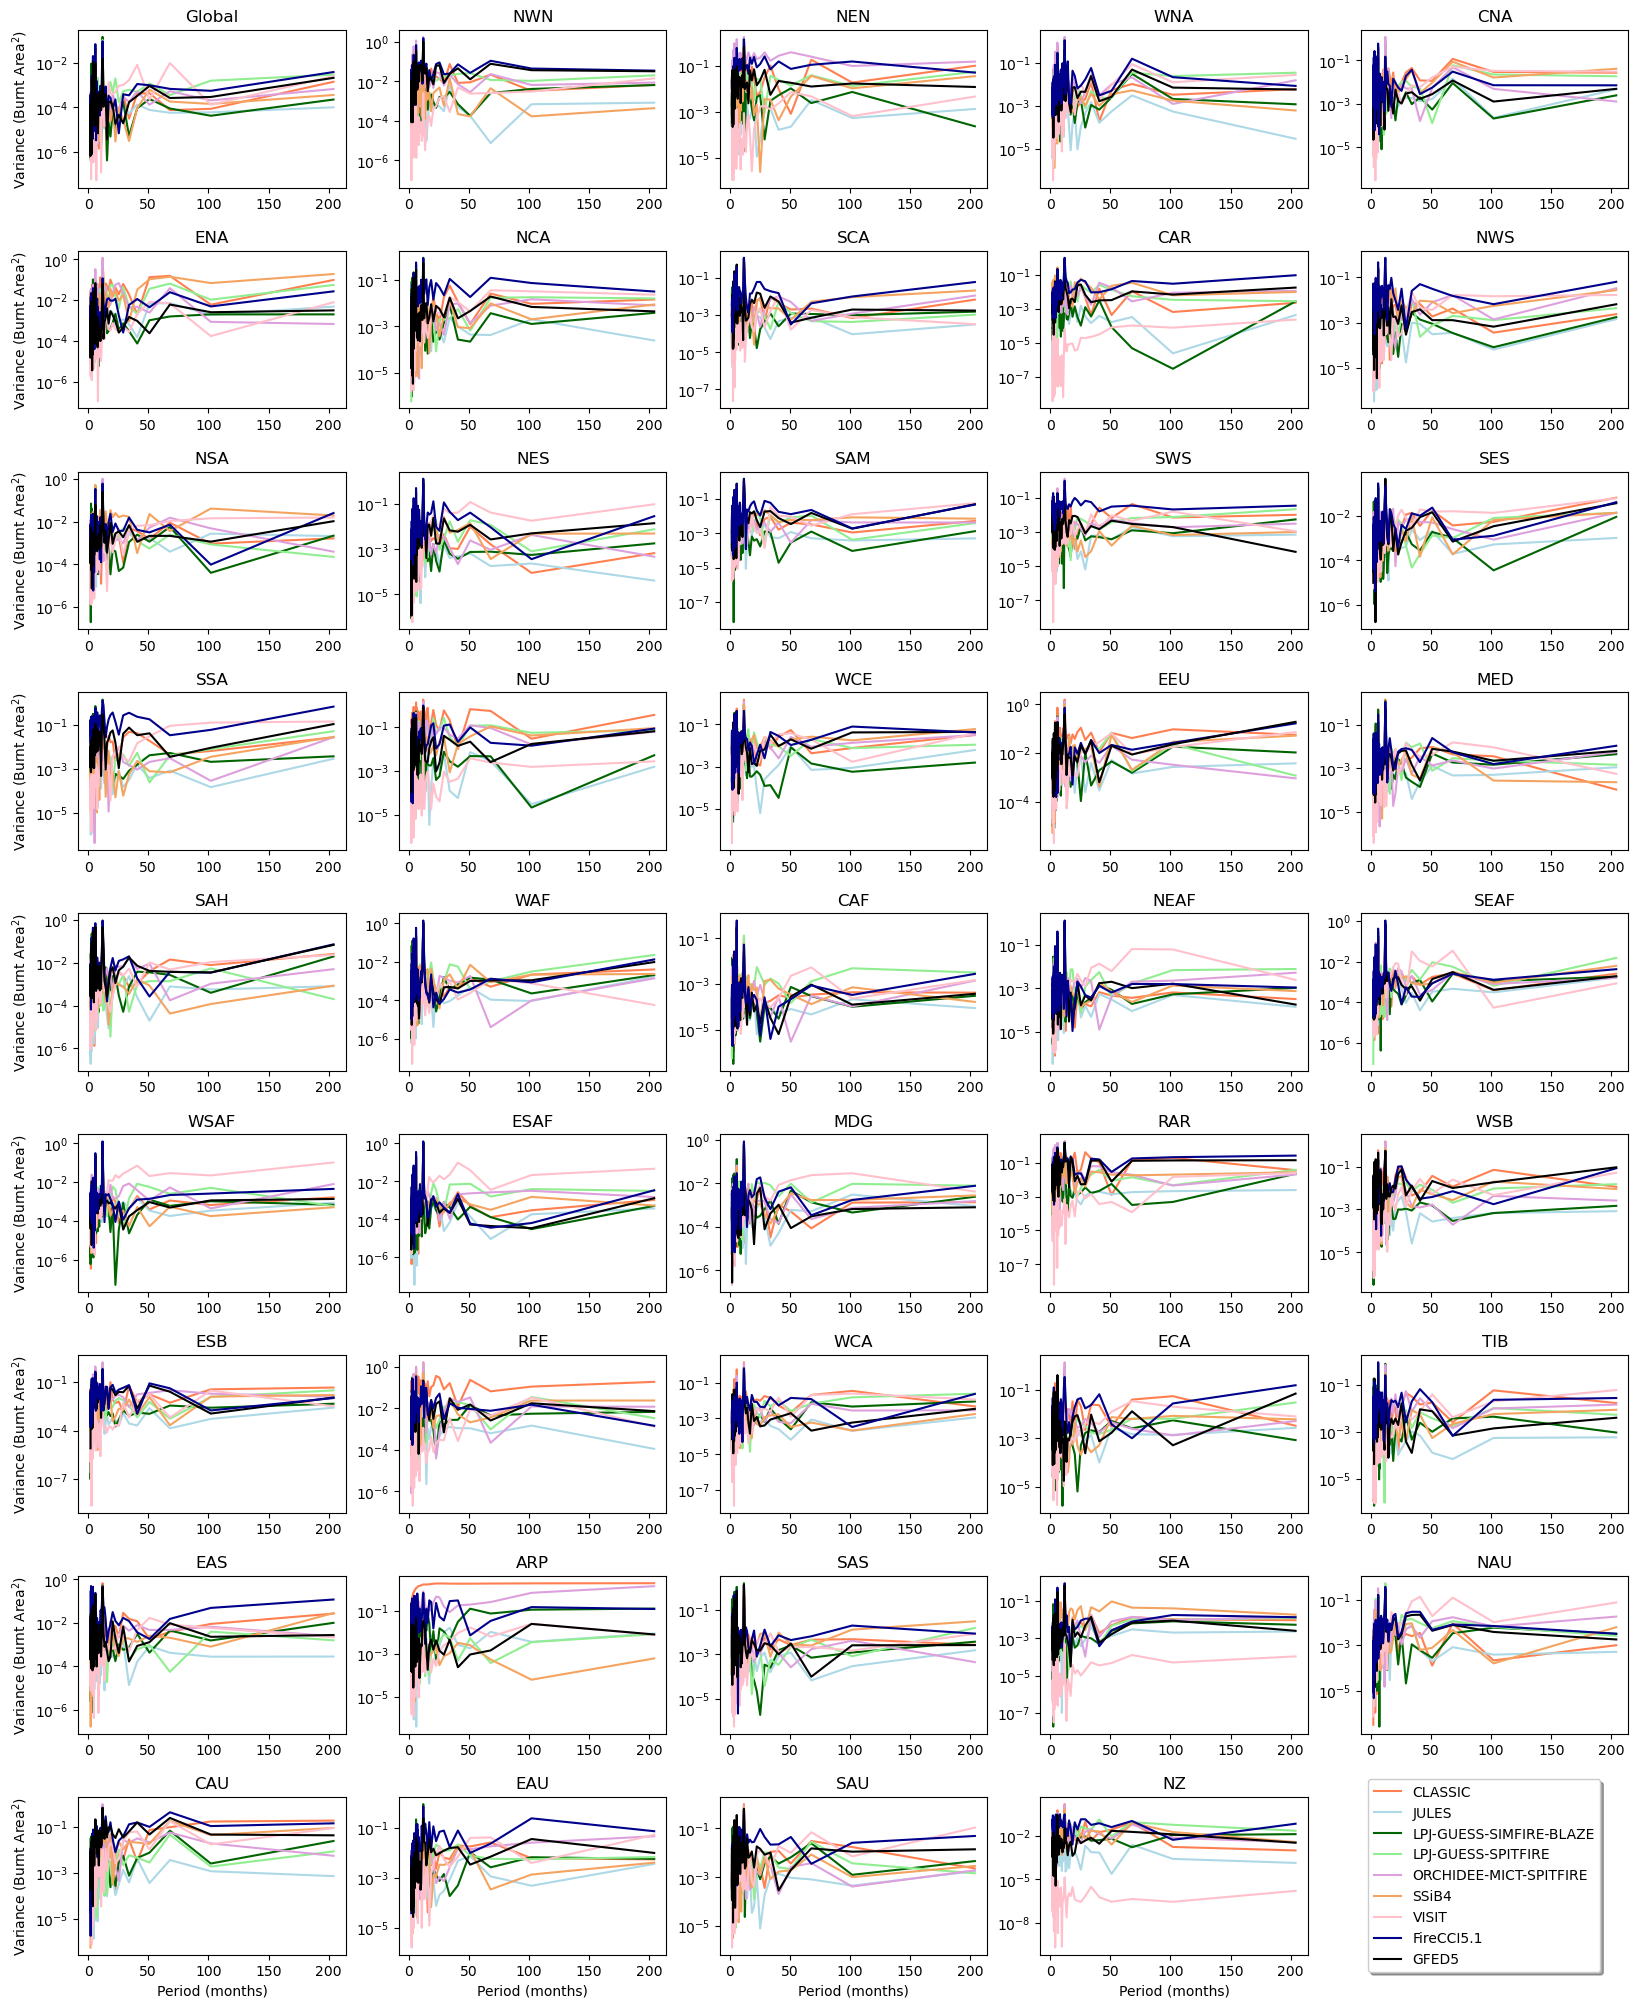

In [9]:
 
##For ALL Regions 

fig, axs = plt.subplots(9, 5, figsize=(20, 25))
axs = axs.ravel()
for idx, regionname in enumerate(obsclim_0319_Ranom.columns.unique(level='Region')):
    ax = axs[idx+1]
    for model_name in obsclim_0319_Ranom[regionname].columns: 
        f, sp = periodogram(obsclim_0319_Ranom[regionname][model_name], detrend='constant',scaling='spectrum')
        ax.plot(1./f, sp, color=model_colours[model_name], label=model_name)
    for obs_name in obs_0319_Ranom[regionname].columns:
        if obs_name == 'GFED5' or obs_name == 'FireCCI5.1':
            f, sp = periodogram(obs_0319_Ranom[regionname][obs_name], detrend='constant',scaling='spectrum')
            ax.plot(1./f, sp, color=obs_colours[obs_name], label=obs_name)  
    ax.set_yscale('log')
    ax.set_title(regionname)
    ax.set_xlabel(' ') 
    ax.set_ylabel(' ')    

plt.delaxes(axs[-1])
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.9, box.height])
ax.legend(bbox_to_anchor=(1.2, 0.5), loc="center left",
          fancybox=True, shadow=True, ncol=1)

###One plot for global
ax = axs[0]
for model_name in obsclim_0319_Ranom_glob.columns:
    f, sp = periodogram(obsclim_0319_Ranom_glob[model_name], detrend='constant',scaling='spectrum')
    ax.plot(1./f, sp, color=model_colours[model_name], label=model_name)
for obs_name in obs_0319_Ranom_glob.columns:
    if obs_name == 'GFED5' or obs_name == 'FireCCI5.1':
        f, sp = periodogram(obs_0319_Ranom_glob[obs_name], detrend='constant',scaling='spectrum')
        ax.plot(1./f, sp, color=obs_colours[obs_name], label=obs_name)    
ax.set_yscale('log')
ax.set_xlabel(' ')
ax.set_ylabel(' ')
ax.set_title('Global')


#Set the axis labels
for ax in axs[40:44]:
    ax.set_xlabel('Period (months)')
PlotsNos = [0,5,10,15,20,25,30,35,40]   
for ax in axs[PlotsNos]:
    ax.set_ylabel('Variance (Burnt Area$^2$)')    
plt.subplots_adjust(hspace=0.4)   
#plt.tight_layout()
plt.savefig('/scratch/cburton/scratch/ISIMIP3a/Draft3.0/PowerSpectra_AR6regions_ALL_Ranom.png',facecolor='w', transparent=False)
plt.show()



# Three PDFs of all 3 forcings - for info, not used in paper

/var/tmp/ipykernel_43122/2383749587.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(obsclim_CC_glob_Nanom, kde=True, color="blue",label='fact PD',fit_kws={"linewidth":2.5,"color":"darkblue"})
/var/tmp/ipykernel_43122/2383749587.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(counterclim_

620
736


/var/tmp/ipykernel_43122/2383749587.py:25: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(Counterclim, kde=True, color="orange",label='c.factual',fit_kws={"linewidth":2.5,"color":"darkorange"})
/var/tmp/ipykernel_43122/2383749587.py:34: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ObsclimLUC, kd

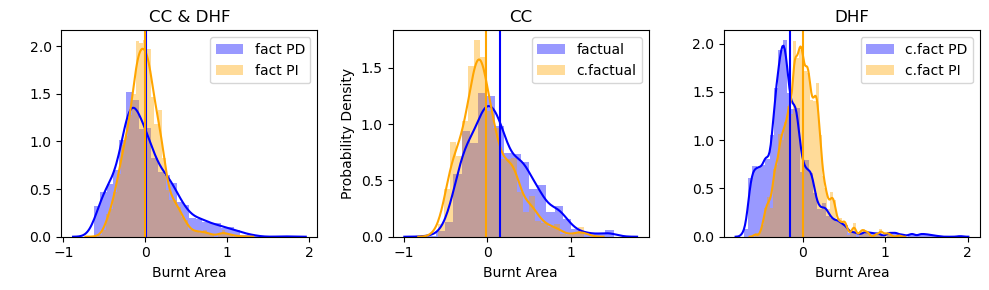

/var/tmp/ipykernel_43122/2383749587.py:53: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ObsclimCCArray.append(draw_bs_replicates(obsclim_CC_glob_Nanom[model_name], np.int(100000*weights['Global'][model_name][0])))
/var/tmp/ipykernel_43122/2383749587.py:54: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to revie

obsclim
counterclim
CC
0.8011890302371668
KstestResult(statistic=0.17751710068402737, pvalue=0.0)


/var/tmp/ipykernel_43122/2383749587.py:84: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ObsclimCC, kde=True, color="sandybrown",label='fact PD',fit_kws={"linewidth":2.5,"color":"darkblue"})
/var/tmp/ipykernel_43122/2383749587.py:85: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(CounterclimCC, k

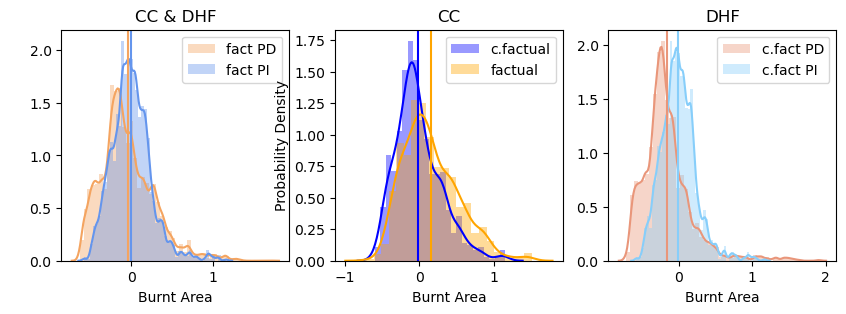

In [84]:


##CC:
obsclim_CC_glob_Nanom = (obsclim_0319_glob-obsclim_global_PI.mean())/obsclim_global_PI.mean()
counterclim_CC_glob_Nanom = (obsclim_global_PI-obsclim_global_PI.mean())/obsclim_global_PI.mean()

fig = plt.subplots(1,3, figsize=(10, 3))

plt.subplot(1,3,1)
sns.distplot(obsclim_CC_glob_Nanom, kde=True, color="blue",label='fact PD',fit_kws={"linewidth":2.5,"color":"darkblue"})
sns.distplot(counterclim_CC_glob_Nanom, kde=True, color="orange",label='fact PI',fit_kws={"linewidth":2.5,"color":"darkorange"})
plt.axvline(x=np.nanmean(obsclim_CC_glob_Nanom) , color='blue')
plt.axvline(x=np.nanmean(counterclim_CC_glob_Nanom), color='orange')
plt.legend(loc='best')
plt.title('CC & DHF')
plt.ylabel(' ')
plt.xlabel('Burnt Area')
plt.legend(loc='best')

ALL_CC = (np.count_nonzero(obsclim_CC_glob_Nanom > (np.nanmean(counterclim_CC_glob_Nanom))))
NAT_CC = (np.count_nonzero(counterclim_CC_glob_Nanom > (np.nanmean(counterclim_CC_glob_Nanom))))
print(ALL_CC)
print(NAT_CC)

plt.subplot(1,3,2)
sns.distplot(Obsclim, kde=True, color="blue",label='factual',fit_kws={"linewidth":2.5,"color":"darkblue"})
sns.distplot(Counterclim, kde=True, color="orange",label='c.factual',fit_kws={"linewidth":2.5,"color":"darkorange"})
plt.axvline(x=np.nanmean(Obsclim) , color='blue')
plt.axvline(x=np.nanmean(Counterclim), color='orange')
plt.title('CC')
plt.legend(loc='best')
plt.xlabel('Burnt Area')
plt.ylabel('Probability Density')

plt.subplot(1,3,3)
sns.distplot(ObsclimLUC, kde=True, color="blue",label='c.fact PD',fit_kws={"linewidth":2.5,"color":"darkblue"})
sns.distplot(CounterclimLUC, kde=True, color="orange",label='c.fact PI',fit_kws={"linewidth":2.5,"color":"darkorange"})
plt.axvline(x=np.nanmean(ObsclimLUC) , color='blue')
plt.axvline(x=np.nanmean(CounterclimLUC), color='orange')
plt.legend(loc='best')
plt.title('DHF')
plt.ylabel(' ')
plt.xlabel('Burnt Area')
plt.legend(loc='best')
plt.tight_layout()

plt.show()


#CC only
ObsclimCCArray = []
CounterclimCCArray = []

for model_name in obsclim_CC_glob_Nanom: 
    ObsclimCCArray.append(draw_bs_replicates(obsclim_CC_glob_Nanom[model_name], np.int(100000*weights['Global'][model_name][0])))   
    CounterclimCCArray.append(draw_bs_replicates(counterclim_CC_glob_Nanom[model_name],  np.int(100000*weights['Global'][model_name][0])))
print("obsclim")
ObsclimCC = []
for n in np.arange(0,7):
    for i in ObsclimCCArray[n]:
        i = ma.masked_where(np.isnan(i),i)
        i = ma.masked_where(np.isinf(i),i)
        ObsclimCC.append(i)

print("counterclim")
CounterclimCC = []
for n in np.arange(0,7):
    for i in CounterclimCCArray[n]:
        i = ma.masked_where(np.isnan(i),i)
        i = ma.masked_where(np.isinf(i),i)
        CounterclimCC.append(i)

        
#Try Eddy's idea to separate out CC & LUC together
ALL_CC = (np.count_nonzero(ObsclimCC > (np.nanmean(CounterclimCC))))
NAT_CC = (np.count_nonzero(CounterclimCC > (np.nanmean(CounterclimCC))))
RR_CC = ALL_CC/NAT_CC
stat_CC = stats.kstest(ObsclimCC, CounterclimCC)
print('CC')
print(RR_CC)
print(stat_CC)

fig = plt.subplots(1,3, figsize=(10, 3))

plt.subplot(1,3,1)
sns.distplot(ObsclimCC, kde=True, color="sandybrown",label='fact PD',fit_kws={"linewidth":2.5,"color":"darkblue"})
sns.distplot(CounterclimCC, kde=True, color="cornflowerblue",label='fact PI',fit_kws={"linewidth":2.5,"color":"darkorange"})
plt.axvline(x=np.nanmean(ObsclimCC) , color='sandybrown')
plt.axvline(x=np.nanmean(CounterclimCC), color='cornflowerblue')
plt.legend(loc='best')
plt.title('CC & DHF')
plt.ylabel(' ')
plt.xlabel('Burnt Area')
plt.legend(loc='best')

plt.subplot(1,3,2)
sns.distplot(Counterclim, kde=True, color="blue",label='c.factual',fit_kws={"linewidth":2.5,"color":"darkorange"})
sns.distplot(Obsclim, kde=True, color="orange",label='factual',fit_kws={"linewidth":2.5,"color":"darkblue"})
plt.axvline(x=np.nanmean(Obsclim) , color='orange')
plt.axvline(x=np.nanmean(Counterclim), color='blue')
plt.title('CC')
plt.legend(loc='best')
plt.xlabel('Burnt Area')
plt.ylabel('Probability Density')

plt.subplot(1,3,3)
sns.distplot(ObsclimLUC, kde=True, color="darksalmon",label='c.fact PD',fit_kws={"linewidth":2.5,"color":"darkblue"})
sns.distplot(CounterclimLUC, kde=True, color="lightskyblue",label='c.fact PI',fit_kws={"linewidth":2.5,"color":"darkorange"})
plt.axvline(x=np.nanmean(ObsclimLUC) , color='darksalmon')
plt.axvline(x=np.nanmean(CounterclimLUC), color='lightskyblue')
plt.legend(loc='best')
plt.title('DHF')
plt.ylabel(' ')
plt.xlabel('Burnt Area')
plt.legend(loc='best')
plt.show()





# QQ plot global (tests for the review)

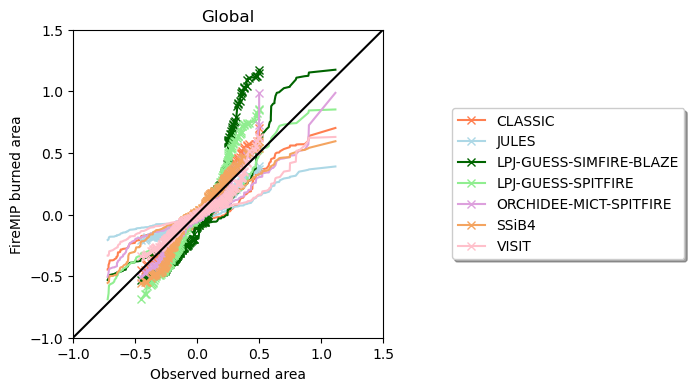

In [10]:

model_colours = {'JULES': 'lightblue', 
              'CLASSIC': 'coral', 
              'SSiB4': 'sandybrown',
              'LPJ-GUESS-SPITFIRE': 'lightgreen',
            'LPJ-GUESS-SIMFIRE-BLAZE': 'darkgreen',
            'ORCHIDEE-MICT-SPITFIRE':'plum',
             'VISIT':'pink'}

fig, axs = plt.subplots(1, 1, figsize=(4,4))
    

#Now do the global plot
for model_name in obsclim_0319_Ranom_glob.columns:
    plt.plot(np.sort(obs_0319_Ranom_glob['GFED5']), np.sort(obsclim_0319_Ranom_glob[model_name]), marker='x', color=model_colours[model_name], label=model_name)
    plt.plot(np.sort(obs_0319_Ranom_glob['FireCCI5.1']), np.sort(obsclim_0319_Ranom_glob[model_name]), color=model_colours[model_name])
         
axis_min=-1.0
axis_max=1.5
plt.plot([axis_min,axis_max],[axis_min,axis_max],color="k")
plt.ylim(axis_min,axis_max)
plt.xlim(axis_min,axis_max)    
plt.title('Global')

plt.legend(bbox_to_anchor=(1.2, 0.5), loc="center left",
          fancybox=True, shadow=True, ncol=1)

#Set the axis labels
plt.xlabel('Observed burned area')
plt.ylabel('FireMIP burned area')    

plt.show()



# Analysis for Review: QQ plots by percentiles (GLOBAL)



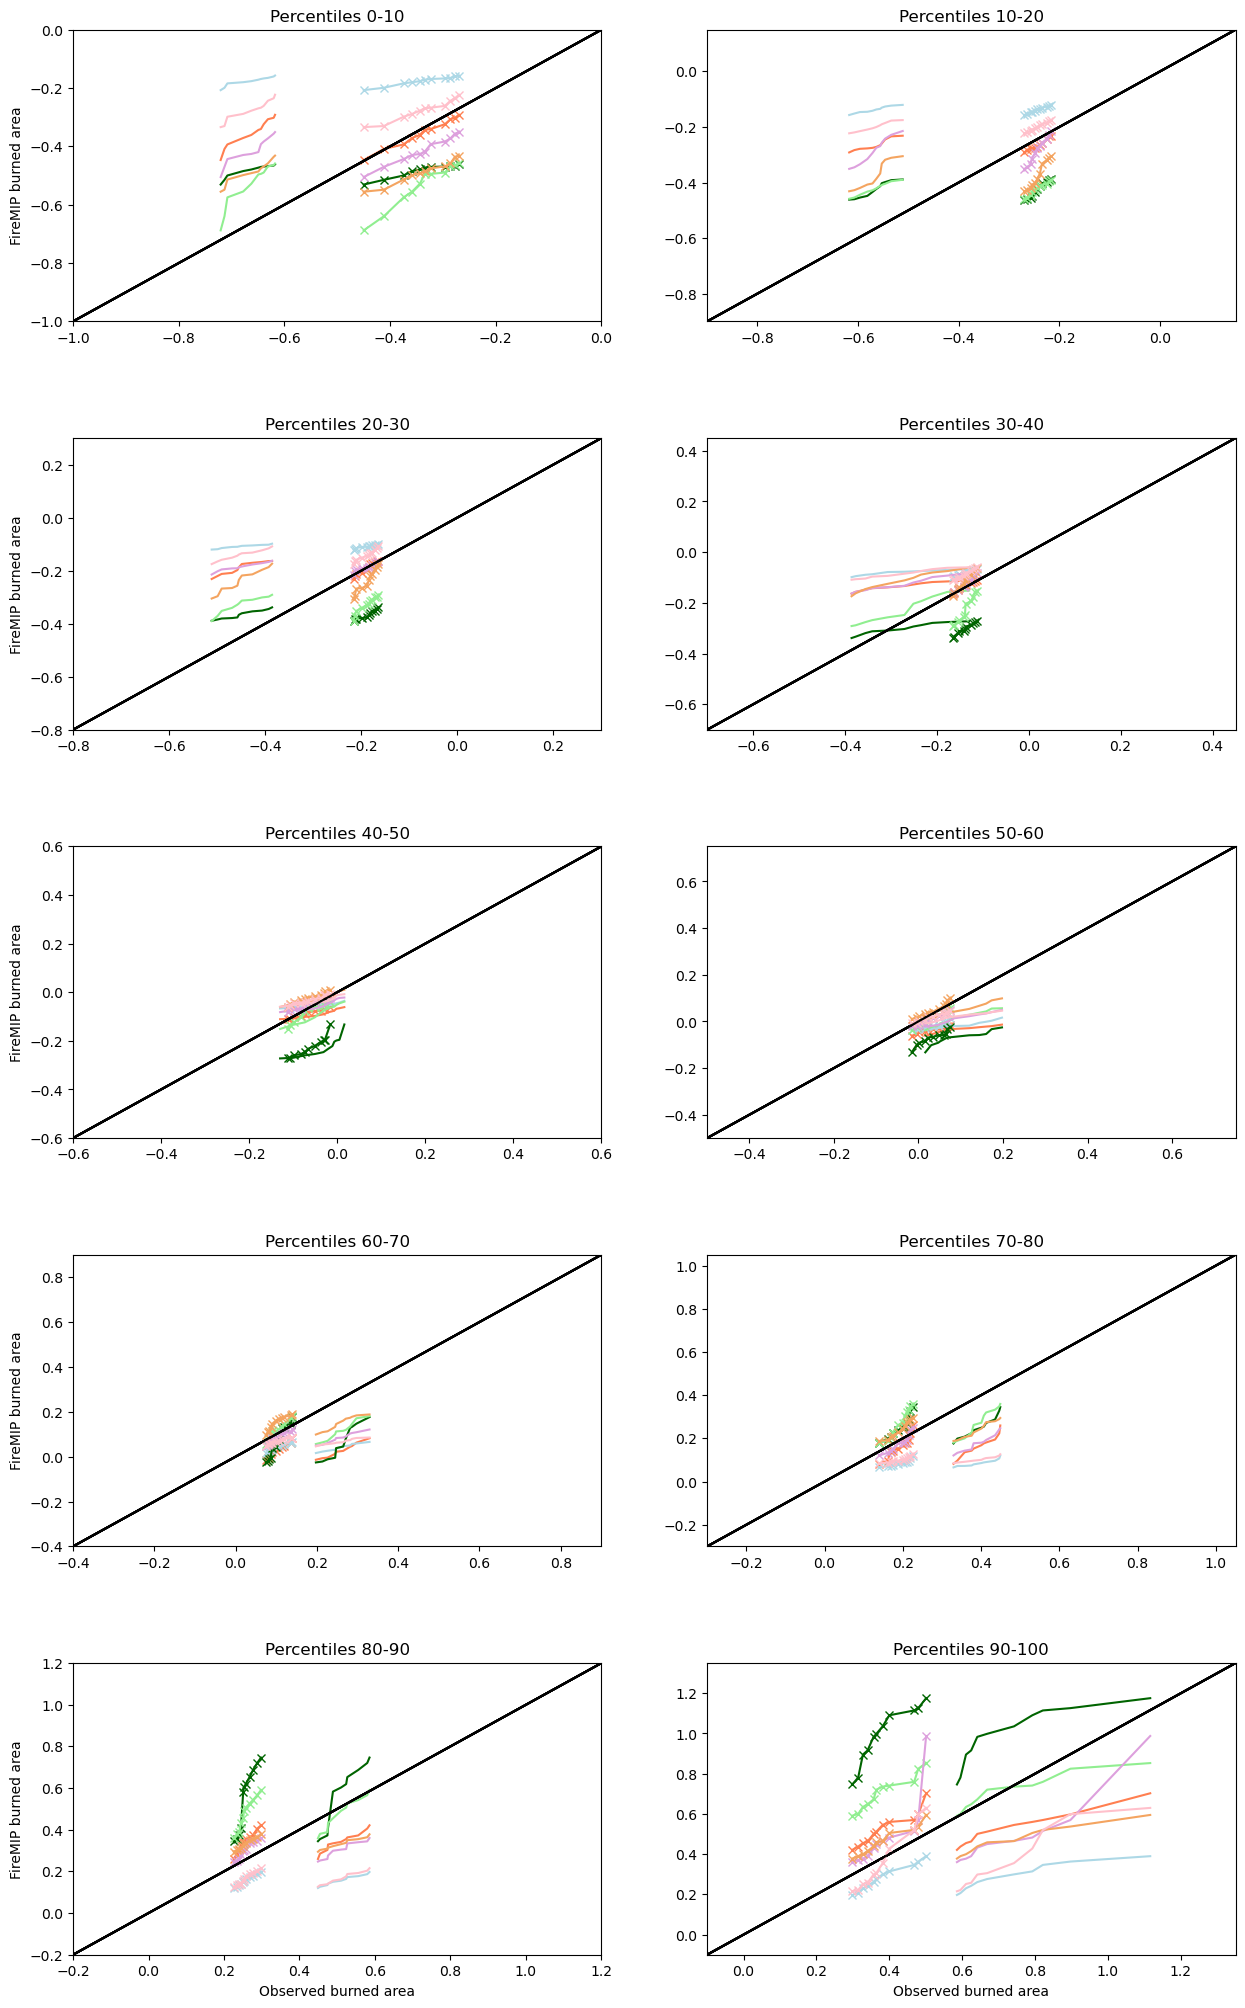

In [23]:
model_colours = {'JULES': 'lightblue', 
              'CLASSIC': 'coral', 
              'SSiB4': 'sandybrown',
              'LPJ-GUESS-SPITFIRE': 'lightgreen',
            'LPJ-GUESS-SIMFIRE-BLAZE': 'darkgreen',
            'ORCHIDEE-MICT-SPITFIRE':'plum',
             'VISIT':'pink'}

fig, axs = plt.subplots(5, 2, figsize=(15, 25))
axs = axs.ravel()

n = 0
x = 0
y = -1.0
for idx in np.arange(10):
    quantiles = np.arange(n, n+11, 1)
    ax = axs[idx]
    for model_name in obsclim_0319_Ranom_glob.columns:
        GFED = []
        FireCCI = []
        model = []
        for quantile in quantiles:
            GFED.append(np.percentile(obs_0319_Ranom_glob['GFED5'], quantile))
            FireCCI.append(np.percentile(obs_0319_Ranom_glob['FireCCI5.1'], quantile))
            model.append(np.percentile(obsclim_0319_Ranom_glob[model_name], quantile))
        ax.plot(np.sort(GFED), np.sort(model), marker='x', color=model_colours[model_name], label=model_name)
        ax.plot(np.sort(FireCCI), np.sort(model), color=model_colours[model_name])

        axis_min=y
        axis_max=x
        ax.set_xlabel('  ')
        ax.set_ylabel(' ')
        ax.plot([axis_min,axix_max],[axis_min,axix_max],color="k")
        ax.set_ylim(axis_min,axis_max)
        ax.set_xlim(axis_min,axis_max)  
        ax.set_title('Percentiles '+str(n)+'-'+str(n+10))
    x = x+0.15
    y = y+0.1
    n = n+10
    
#Set the axis labels
PlotsNos = [8,9] 
for ax in axs[PlotsNos]:
    ax.set_xlabel('Observed burned area')
PlotsNos = [0,2,4,6,8]   
for ax in axs[PlotsNos]:
    ax.set_ylabel('FireMIP burned area')    

plt.subplots_adjust(hspace=0.4) 
plt.savefig(os.path.join('/scratch/cburton/scratch/ISIMIP3a/GLOBAL_QQ_Quantiles.png'), dpi=400, bbox_inches='tight')
plt.show()



# Analysis for Review: QQ plots by percentiles (CAU)


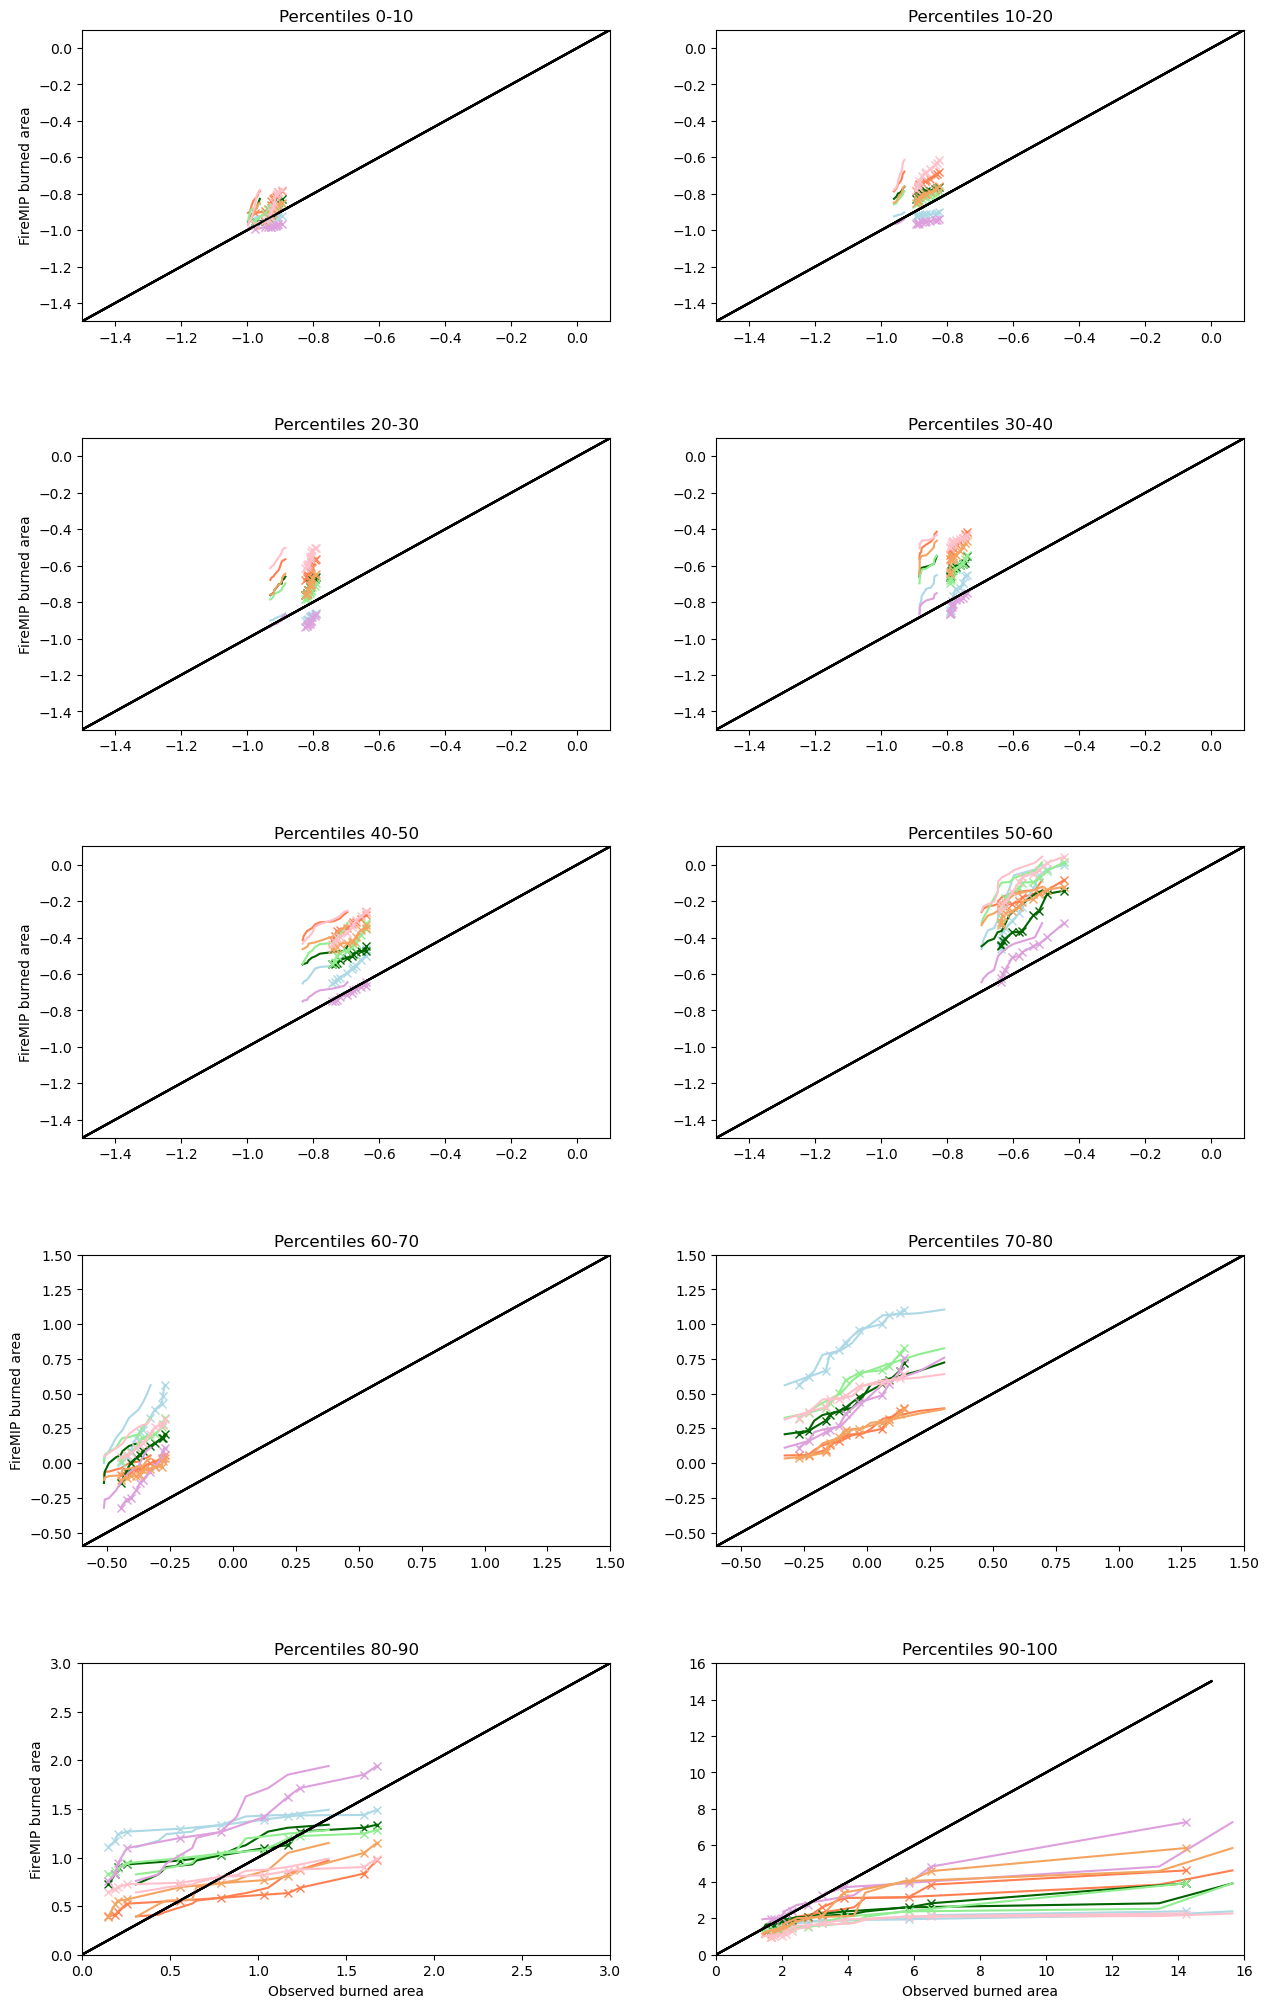

In [37]:
model_colours = {'JULES': 'lightblue', 
              'CLASSIC': 'coral', 
              'SSiB4': 'sandybrown',
              'LPJ-GUESS-SPITFIRE': 'lightgreen',
            'LPJ-GUESS-SIMFIRE-BLAZE': 'darkgreen',
            'ORCHIDEE-MICT-SPITFIRE':'plum',
             'VISIT':'pink'}

fig, axs = plt.subplots(5, 2, figsize=(15, 25))
axs = axs.ravel()

n = 0
x = 0
y = -1.0
for idx in np.arange(10):
    quantiles = np.arange(n, n+11, 1)
    ax = axs[idx]       
    for model_name in obsclim_0319_Ranom['CAU'].columns:
        GFED = []
        FireCCI = []
        model = []
        for quantile in quantiles:            
            GFED.append(np.percentile(obs_0319_Ranom['CAU']['GFED5'], quantile))
            FireCCI.append(np.percentile(obs_0319_Ranom['CAU']['FireCCI5.1'], quantile))
            model.append(np.percentile(obsclim_0319_Ranom['CAU'][model_name], quantile))
        ax.plot(np.sort(GFED), np.sort(model), marker='x', color=model_colours[model_name], label=model_name)
        ax.plot(np.sort(FireCCI), np.sort(model), color=model_colours[model_name])

        if idx < 6:
            axis_min=-1.5
            axis_max=0.1
        elif idx == 6 or idx == 7:
            axis_min=-0.6
            axis_max=1.5
        elif idx == 8:
            axis_min=0.0
            axis_max=3.0
        else:
            axis_min=0.0
            axis_max=16.0           
        ax.set_xlabel('  ')
        ax.set_ylabel(' ')
        ax.plot([axis_min,axix_max],[axis_min,axix_max],color="k")
        ax.set_ylim(axis_min,axis_max)
        ax.set_xlim(axis_min,axis_max)  
        ax.set_title('Percentiles '+str(n)+'-'+str(n+10))
    x = x+0.15
    y = y+0.1
    n = n+10
    
#Set the axis labels
PlotsNos = [8,9] 
for ax in axs[PlotsNos]:
    ax.set_xlabel('Observed burned area')
PlotsNos = [0,2,4,6,8]   
for ax in axs[PlotsNos]:
    ax.set_ylabel('FireMIP burned area')    

plt.subplots_adjust(hspace=0.4)  
plt.savefig(os.path.join('/scratch/cburton/scratch/ISIMIP3a/CAU_QQ_Quantiles.png'), dpi=400, bbox_inches='tight')
plt.show()

